In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "0:1"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 87612 images
Dataset type val label type: species


Loaded 21905 images
Dataset type test label type: species


Loaded 81589 images
Dataset type test label type: species


Loaded 78017 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1 dydmderv


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-dydmderv:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                       | 0/685 [00:00<?, ?it/s]

  0%|▏                                                                                              | 1/685 [00:00<08:41,  1.31it/s]

  0%|▎                                                                                              | 2/685 [00:00<05:03,  2.25it/s]

  0%|▍                                                                                              | 3/685 [00:01<03:53,  2.93it/s]

  1%|▌                                                                                              | 4/685 [00:01<03:19,  3.41it/s]

  1%|▋                                                                                              | 5/685 [00:01<03:01,  3.74it/s]

  1%|▊                                                                                              | 6/685 [00:01<02:50,  3.98it/s]

  1%|▉                                                                                              | 7/685 [00:02<02:43,  4.15it/s]

  1%|█                                                                                              | 8/685 [00:02<02:38,  4.27it/s]

  1%|█▏                                                                                             | 9/685 [00:02<02:35,  4.35it/s]

  1%|█▎                                                                                            | 10/685 [00:02<02:33,  4.41it/s]

  2%|█▌                                                                                            | 11/685 [00:02<02:31,  4.45it/s]

  2%|█▋                                                                                            | 12/685 [00:03<02:30,  4.48it/s]

  2%|█▊                                                                                            | 13/685 [00:03<02:29,  4.50it/s]

  2%|█▉                                                                                            | 14/685 [00:03<02:28,  4.51it/s]

  2%|██                                                                                            | 15/685 [00:03<02:28,  4.52it/s]

  2%|██▏                                                                                           | 16/685 [00:04<02:27,  4.53it/s]

  2%|██▎                                                                                           | 17/685 [00:04<02:27,  4.54it/s]

  3%|██▍                                                                                           | 18/685 [00:04<02:26,  4.54it/s]

  3%|██▌                                                                                           | 19/685 [00:04<02:26,  4.54it/s]

  3%|██▋                                                                                           | 20/685 [00:04<02:26,  4.54it/s]

  3%|██▉                                                                                           | 21/685 [00:05<02:26,  4.54it/s]

  3%|███                                                                                           | 22/685 [00:05<02:25,  4.54it/s]

  3%|███▏                                                                                          | 23/685 [00:05<02:25,  4.54it/s]

  4%|███▎                                                                                          | 24/685 [00:05<02:25,  4.54it/s]

  4%|███▍                                                                                          | 25/685 [00:06<02:25,  4.55it/s]

  4%|███▌                                                                                          | 26/685 [00:06<02:25,  4.54it/s]

  4%|███▋                                                                                          | 27/685 [00:06<02:24,  4.54it/s]

  4%|███▊                                                                                          | 28/685 [00:06<02:24,  4.55it/s]

  4%|███▉                                                                                          | 29/685 [00:06<02:24,  4.55it/s]

  4%|████                                                                                          | 30/685 [00:07<02:24,  4.54it/s]

  5%|████▎                                                                                         | 31/685 [00:07<02:23,  4.54it/s]

  5%|████▍                                                                                         | 32/685 [00:07<02:23,  4.54it/s]

  5%|████▌                                                                                         | 33/685 [00:07<02:23,  4.55it/s]

  5%|████▋                                                                                         | 34/685 [00:08<02:23,  4.55it/s]

  5%|████▊                                                                                         | 35/685 [00:08<02:23,  4.54it/s]

  5%|████▉                                                                                         | 36/685 [00:08<02:22,  4.54it/s]

  5%|█████                                                                                         | 37/685 [00:08<02:22,  4.55it/s]

  6%|█████▏                                                                                        | 38/685 [00:08<02:22,  4.54it/s]

  6%|█████▎                                                                                        | 39/685 [00:09<02:22,  4.54it/s]

  6%|█████▍                                                                                        | 40/685 [00:09<02:22,  4.54it/s]

  6%|█████▋                                                                                        | 41/685 [00:09<02:21,  4.54it/s]

  6%|█████▊                                                                                        | 42/685 [00:09<02:21,  4.54it/s]

  6%|█████▉                                                                                        | 43/685 [00:10<02:21,  4.54it/s]

  6%|██████                                                                                        | 44/685 [00:10<02:21,  4.54it/s]

  7%|██████▏                                                                                       | 45/685 [00:10<02:21,  4.53it/s]

  7%|██████▎                                                                                       | 46/685 [00:10<02:20,  4.54it/s]

  7%|██████▍                                                                                       | 47/685 [00:10<02:20,  4.54it/s]

  7%|██████▌                                                                                       | 48/685 [00:11<02:20,  4.54it/s]

  7%|██████▋                                                                                       | 49/685 [00:11<02:20,  4.54it/s]

  7%|██████▊                                                                                       | 50/685 [00:11<02:19,  4.54it/s]

  7%|██████▉                                                                                       | 51/685 [00:11<02:19,  4.54it/s]

  8%|███████▏                                                                                      | 52/685 [00:11<02:19,  4.53it/s]

  8%|███████▎                                                                                      | 53/685 [00:12<02:19,  4.54it/s]

  8%|███████▍                                                                                      | 54/685 [00:12<02:19,  4.54it/s]

  8%|███████▌                                                                                      | 55/685 [00:12<02:18,  4.54it/s]

  8%|███████▋                                                                                      | 56/685 [00:12<02:18,  4.53it/s]

  8%|███████▊                                                                                      | 57/685 [00:13<02:18,  4.54it/s]

  8%|███████▉                                                                                      | 58/685 [00:13<02:18,  4.54it/s]

  9%|████████                                                                                      | 59/685 [00:13<02:17,  4.54it/s]

  9%|████████▏                                                                                     | 60/685 [00:13<02:17,  4.54it/s]

  9%|████████▎                                                                                     | 61/685 [00:13<02:17,  4.54it/s]

  9%|████████▌                                                                                     | 62/685 [00:14<02:17,  4.54it/s]

  9%|████████▋                                                                                     | 63/685 [00:14<02:17,  4.53it/s]

  9%|████████▊                                                                                     | 64/685 [00:14<02:16,  4.54it/s]

  9%|████████▉                                                                                     | 65/685 [00:14<02:16,  4.54it/s]

 10%|█████████                                                                                     | 66/685 [00:15<02:16,  4.53it/s]

 10%|█████████▏                                                                                    | 67/685 [00:15<02:16,  4.53it/s]

 10%|█████████▎                                                                                    | 68/685 [00:15<02:16,  4.53it/s]

 10%|█████████▍                                                                                    | 69/685 [00:15<02:15,  4.54it/s]

 10%|█████████▌                                                                                    | 70/685 [00:15<02:15,  4.53it/s]

 10%|█████████▋                                                                                    | 71/685 [00:16<02:15,  4.54it/s]

 11%|█████████▉                                                                                    | 72/685 [00:16<02:15,  4.54it/s]

 11%|██████████                                                                                    | 73/685 [00:16<02:14,  4.53it/s]

 11%|██████████▏                                                                                   | 74/685 [00:16<02:14,  4.54it/s]

 11%|██████████▎                                                                                   | 75/685 [00:17<02:14,  4.54it/s]

 11%|██████████▍                                                                                   | 76/685 [00:17<02:14,  4.54it/s]

 11%|██████████▌                                                                                   | 77/685 [00:17<02:14,  4.53it/s]

 11%|██████████▋                                                                                   | 78/685 [00:17<02:13,  4.54it/s]

 12%|██████████▊                                                                                   | 79/685 [00:17<02:13,  4.54it/s]

 12%|██████████▉                                                                                   | 80/685 [00:18<02:13,  4.54it/s]

 12%|███████████                                                                                   | 81/685 [00:18<02:13,  4.54it/s]

 12%|███████████▎                                                                                  | 82/685 [00:18<02:12,  4.54it/s]

 12%|███████████▍                                                                                  | 83/685 [00:18<02:12,  4.54it/s]

 12%|███████████▌                                                                                  | 84/685 [00:19<02:12,  4.54it/s]

 12%|███████████▋                                                                                  | 85/685 [00:19<02:12,  4.54it/s]

 13%|███████████▊                                                                                  | 86/685 [00:19<02:11,  4.54it/s]

 13%|███████████▉                                                                                  | 87/685 [00:19<02:11,  4.54it/s]

 13%|████████████                                                                                  | 88/685 [00:19<02:11,  4.54it/s]

 13%|████████████▏                                                                                 | 89/685 [00:20<02:11,  4.54it/s]

 13%|████████████▎                                                                                 | 90/685 [00:20<02:11,  4.54it/s]

 13%|████████████▍                                                                                 | 91/685 [00:20<02:10,  4.54it/s]

 13%|████████████▌                                                                                 | 92/685 [00:20<02:10,  4.54it/s]

 14%|████████████▊                                                                                 | 93/685 [00:21<02:10,  4.54it/s]

 14%|████████████▉                                                                                 | 94/685 [00:21<02:10,  4.53it/s]

 14%|█████████████                                                                                 | 95/685 [00:21<02:09,  4.54it/s]

 14%|█████████████▏                                                                                | 96/685 [00:21<02:09,  4.54it/s]

 14%|█████████████▎                                                                                | 97/685 [00:21<02:09,  4.54it/s]

 14%|█████████████▍                                                                                | 98/685 [00:22<02:09,  4.54it/s]

 14%|█████████████▌                                                                                | 99/685 [00:22<02:09,  4.54it/s]

 15%|█████████████▌                                                                               | 100/685 [00:22<02:08,  4.54it/s]

 15%|█████████████▋                                                                               | 101/685 [00:22<02:08,  4.53it/s]

 15%|█████████████▊                                                                               | 102/685 [00:23<02:08,  4.53it/s]

 15%|█████████████▉                                                                               | 103/685 [00:23<02:08,  4.53it/s]

 15%|██████████████                                                                               | 104/685 [00:23<02:08,  4.53it/s]

 15%|██████████████▎                                                                              | 105/685 [00:23<02:07,  4.53it/s]

 15%|██████████████▍                                                                              | 106/685 [00:23<02:07,  4.53it/s]

 16%|██████████████▌                                                                              | 107/685 [00:24<02:07,  4.53it/s]

 16%|██████████████▋                                                                              | 108/685 [00:24<02:07,  4.53it/s]

 16%|██████████████▊                                                                              | 109/685 [00:24<02:07,  4.53it/s]

 16%|██████████████▉                                                                              | 110/685 [00:24<02:06,  4.53it/s]

 16%|███████████████                                                                              | 111/685 [00:24<02:06,  4.54it/s]

 16%|███████████████▏                                                                             | 112/685 [00:25<02:06,  4.53it/s]

 16%|███████████████▎                                                                             | 113/685 [00:25<02:06,  4.54it/s]

 17%|███████████████▍                                                                             | 114/685 [00:25<02:05,  4.54it/s]

 17%|███████████████▌                                                                             | 115/685 [00:25<02:05,  4.53it/s]

 17%|███████████████▋                                                                             | 116/685 [00:26<02:05,  4.54it/s]

 17%|███████████████▉                                                                             | 117/685 [00:26<02:05,  4.54it/s]

 17%|████████████████                                                                             | 118/685 [00:26<02:04,  4.54it/s]

 17%|████████████████▏                                                                            | 119/685 [00:26<02:04,  4.53it/s]

 18%|████████████████▎                                                                            | 120/685 [00:26<02:04,  4.54it/s]

 18%|████████████████▍                                                                            | 121/685 [00:27<02:04,  4.54it/s]

 18%|████████████████▌                                                                            | 122/685 [00:27<02:04,  4.54it/s]

 18%|████████████████▋                                                                            | 123/685 [00:27<02:03,  4.54it/s]

 18%|████████████████▊                                                                            | 124/685 [00:27<02:03,  4.54it/s]

 18%|████████████████▉                                                                            | 125/685 [00:28<02:03,  4.54it/s]

 18%|█████████████████                                                                            | 126/685 [00:28<02:03,  4.54it/s]

 19%|█████████████████▏                                                                           | 127/685 [00:28<02:02,  4.54it/s]

 19%|█████████████████▍                                                                           | 128/685 [00:28<02:02,  4.54it/s]

 19%|█████████████████▌                                                                           | 129/685 [00:28<02:02,  4.53it/s]

 19%|█████████████████▋                                                                           | 130/685 [00:29<02:02,  4.54it/s]

 19%|█████████████████▊                                                                           | 131/685 [00:29<02:02,  4.54it/s]

 19%|█████████████████▉                                                                           | 132/685 [00:29<02:01,  4.54it/s]

 19%|██████████████████                                                                           | 133/685 [00:29<02:01,  4.53it/s]

 20%|██████████████████▏                                                                          | 134/685 [00:30<02:01,  4.54it/s]

 20%|██████████████████▎                                                                          | 135/685 [00:30<02:01,  4.54it/s]

 20%|██████████████████▍                                                                          | 136/685 [00:30<02:01,  4.54it/s]

 20%|██████████████████▌                                                                          | 137/685 [00:30<02:00,  4.54it/s]

 20%|██████████████████▋                                                                          | 138/685 [00:30<02:00,  4.54it/s]

 20%|██████████████████▊                                                                          | 139/685 [00:31<02:00,  4.54it/s]

 20%|███████████████████                                                                          | 140/685 [00:31<02:00,  4.54it/s]

 21%|███████████████████▏                                                                         | 141/685 [00:31<01:59,  4.54it/s]

 21%|███████████████████▎                                                                         | 142/685 [00:31<01:59,  4.54it/s]

 21%|███████████████████▍                                                                         | 143/685 [00:32<01:59,  4.54it/s]

 21%|███████████████████▌                                                                         | 144/685 [00:32<01:59,  4.54it/s]

 21%|███████████████████▋                                                                         | 145/685 [00:32<01:58,  4.54it/s]

 21%|███████████████████▊                                                                         | 146/685 [00:32<01:58,  4.54it/s]

 21%|███████████████████▉                                                                         | 147/685 [00:32<01:58,  4.54it/s]

 22%|████████████████████                                                                         | 148/685 [00:33<01:58,  4.54it/s]

 22%|████████████████████▏                                                                        | 149/685 [00:33<01:58,  4.54it/s]

 22%|████████████████████▎                                                                        | 150/685 [00:33<01:57,  4.54it/s]

 22%|████████████████████▌                                                                        | 151/685 [00:33<01:57,  4.54it/s]

 22%|████████████████████▋                                                                        | 152/685 [00:34<01:57,  4.54it/s]

 22%|████████████████████▊                                                                        | 153/685 [00:34<01:57,  4.54it/s]

 22%|████████████████████▉                                                                        | 154/685 [00:34<01:57,  4.53it/s]

 23%|█████████████████████                                                                        | 155/685 [00:34<01:56,  4.53it/s]

 23%|█████████████████████▏                                                                       | 156/685 [00:34<01:56,  4.54it/s]

 23%|█████████████████████▎                                                                       | 157/685 [00:35<01:56,  4.54it/s]

 23%|█████████████████████▍                                                                       | 158/685 [00:35<01:56,  4.54it/s]

 23%|█████████████████████▌                                                                       | 159/685 [00:35<01:55,  4.54it/s]

 23%|█████████████████████▋                                                                       | 160/685 [00:35<01:55,  4.53it/s]

 24%|█████████████████████▊                                                                       | 161/685 [00:36<01:55,  4.53it/s]

 24%|█████████████████████▉                                                                       | 162/685 [00:36<01:55,  4.54it/s]

 24%|██████████████████████▏                                                                      | 163/685 [00:36<01:55,  4.54it/s]

 24%|██████████████████████▎                                                                      | 164/685 [00:36<01:54,  4.53it/s]

 24%|██████████████████████▍                                                                      | 165/685 [00:36<01:54,  4.54it/s]

 24%|██████████████████████▌                                                                      | 166/685 [00:37<01:54,  4.54it/s]

 24%|██████████████████████▋                                                                      | 167/685 [00:37<01:54,  4.54it/s]

 25%|██████████████████████▊                                                                      | 168/685 [00:37<01:53,  4.54it/s]

 25%|██████████████████████▉                                                                      | 169/685 [00:37<01:53,  4.54it/s]

 25%|███████████████████████                                                                      | 170/685 [00:38<01:53,  4.54it/s]

 25%|███████████████████████▏                                                                     | 171/685 [00:38<01:53,  4.53it/s]

 25%|███████████████████████▎                                                                     | 172/685 [00:38<01:53,  4.54it/s]

 25%|███████████████████████▍                                                                     | 173/685 [00:38<01:52,  4.54it/s]

 25%|███████████████████████▌                                                                     | 174/685 [00:38<01:52,  4.54it/s]

 26%|███████████████████████▊                                                                     | 175/685 [00:39<01:52,  4.53it/s]

 26%|███████████████████████▉                                                                     | 176/685 [00:39<01:52,  4.54it/s]

 26%|████████████████████████                                                                     | 177/685 [00:39<01:52,  4.53it/s]

 26%|████████████████████████▏                                                                    | 178/685 [00:39<01:51,  4.54it/s]

 26%|████████████████████████▎                                                                    | 179/685 [00:39<01:51,  4.54it/s]

 26%|████████████████████████▍                                                                    | 180/685 [00:40<01:51,  4.54it/s]

 26%|████████████████████████▌                                                                    | 181/685 [00:40<01:51,  4.54it/s]

 27%|████████████████████████▋                                                                    | 182/685 [00:40<01:50,  4.54it/s]

 27%|████████████████████████▊                                                                    | 183/685 [00:40<01:50,  4.54it/s]

 27%|████████████████████████▉                                                                    | 184/685 [00:41<01:50,  4.54it/s]

 27%|█████████████████████████                                                                    | 185/685 [00:41<01:50,  4.54it/s]

 27%|█████████████████████████▎                                                                   | 186/685 [00:41<01:50,  4.54it/s]

 27%|█████████████████████████▍                                                                   | 187/685 [00:41<01:49,  4.54it/s]

 27%|█████████████████████████▌                                                                   | 188/685 [00:41<01:49,  4.54it/s]

 28%|█████████████████████████▋                                                                   | 189/685 [00:42<01:49,  4.54it/s]

 28%|█████████████████████████▊                                                                   | 190/685 [00:42<01:49,  4.54it/s]

 28%|█████████████████████████▉                                                                   | 191/685 [00:42<01:49,  4.53it/s]

 28%|██████████████████████████                                                                   | 192/685 [00:42<01:48,  4.53it/s]

 28%|██████████████████████████▏                                                                  | 193/685 [00:43<01:48,  4.54it/s]

 28%|██████████████████████████▎                                                                  | 194/685 [00:43<01:48,  4.54it/s]

 28%|██████████████████████████▍                                                                  | 195/685 [00:43<01:48,  4.54it/s]

 29%|██████████████████████████▌                                                                  | 196/685 [00:43<01:47,  4.53it/s]

 29%|██████████████████████████▋                                                                  | 197/685 [00:43<01:47,  4.53it/s]

 29%|██████████████████████████▉                                                                  | 198/685 [00:44<01:47,  4.53it/s]

 29%|███████████████████████████                                                                  | 199/685 [00:44<01:47,  4.54it/s]

 29%|███████████████████████████▏                                                                 | 200/685 [00:44<01:46,  4.53it/s]

 29%|███████████████████████████▎                                                                 | 201/685 [00:44<01:46,  4.53it/s]

 29%|███████████████████████████▍                                                                 | 202/685 [00:45<01:46,  4.53it/s]

 30%|███████████████████████████▌                                                                 | 203/685 [00:45<01:46,  4.53it/s]

 30%|███████████████████████████▋                                                                 | 204/685 [00:45<01:46,  4.54it/s]

 30%|███████████████████████████▊                                                                 | 205/685 [00:45<01:45,  4.53it/s]

 30%|███████████████████████████▉                                                                 | 206/685 [00:45<01:45,  4.53it/s]

 30%|████████████████████████████                                                                 | 207/685 [00:46<01:45,  4.54it/s]

 30%|████████████████████████████▏                                                                | 208/685 [00:46<01:45,  4.54it/s]

 31%|████████████████████████████▍                                                                | 209/685 [00:46<01:44,  4.54it/s]

 31%|████████████████████████████▌                                                                | 210/685 [00:46<01:44,  4.54it/s]

 31%|████████████████████████████▋                                                                | 211/685 [00:47<01:44,  4.54it/s]

 31%|████████████████████████████▊                                                                | 212/685 [00:47<01:44,  4.53it/s]

 31%|████████████████████████████▉                                                                | 213/685 [00:47<01:44,  4.54it/s]

 31%|█████████████████████████████                                                                | 214/685 [00:47<01:43,  4.54it/s]

 31%|█████████████████████████████▏                                                               | 215/685 [00:47<01:43,  4.54it/s]

 32%|█████████████████████████████▎                                                               | 216/685 [00:48<01:43,  4.54it/s]

 32%|█████████████████████████████▍                                                               | 217/685 [00:48<01:43,  4.54it/s]

 32%|█████████████████████████████▌                                                               | 218/685 [00:48<01:42,  4.54it/s]

 32%|█████████████████████████████▋                                                               | 219/685 [00:48<01:42,  4.54it/s]

 32%|█████████████████████████████▊                                                               | 220/685 [00:49<01:42,  4.54it/s]

 32%|██████████████████████████████                                                               | 221/685 [00:49<01:42,  4.53it/s]

 32%|██████████████████████████████▏                                                              | 222/685 [00:49<01:42,  4.53it/s]

 33%|██████████████████████████████▎                                                              | 223/685 [00:49<01:41,  4.53it/s]

 33%|██████████████████████████████▍                                                              | 224/685 [00:49<01:41,  4.54it/s]

 33%|██████████████████████████████▌                                                              | 225/685 [00:50<01:41,  4.54it/s]

 33%|██████████████████████████████▋                                                              | 226/685 [00:50<01:41,  4.53it/s]

 33%|██████████████████████████████▊                                                              | 227/685 [00:50<01:40,  4.53it/s]

 33%|██████████████████████████████▉                                                              | 228/685 [00:50<01:40,  4.54it/s]

 33%|███████████████████████████████                                                              | 229/685 [00:51<01:40,  4.53it/s]

 34%|███████████████████████████████▏                                                             | 230/685 [00:51<01:40,  4.54it/s]

 34%|███████████████████████████████▎                                                             | 231/685 [00:51<01:40,  4.54it/s]

 34%|███████████████████████████████▍                                                             | 232/685 [00:51<01:39,  4.54it/s]

 34%|███████████████████████████████▋                                                             | 233/685 [00:51<01:39,  4.53it/s]

 34%|███████████████████████████████▊                                                             | 234/685 [00:52<01:39,  4.54it/s]

 34%|███████████████████████████████▉                                                             | 235/685 [00:52<01:39,  4.54it/s]

 34%|████████████████████████████████                                                             | 236/685 [00:52<01:39,  4.54it/s]

 35%|████████████████████████████████▏                                                            | 237/685 [00:52<01:38,  4.54it/s]

 35%|████████████████████████████████▎                                                            | 238/685 [00:52<01:38,  4.54it/s]

 35%|████████████████████████████████▍                                                            | 239/685 [00:53<01:38,  4.54it/s]

 35%|████████████████████████████████▌                                                            | 240/685 [00:53<01:38,  4.54it/s]

 35%|████████████████████████████████▋                                                            | 241/685 [00:53<01:37,  4.54it/s]

 35%|████████████████████████████████▊                                                            | 242/685 [00:53<01:37,  4.54it/s]

 35%|████████████████████████████████▉                                                            | 243/685 [00:54<01:37,  4.53it/s]

 36%|█████████████████████████████████▏                                                           | 244/685 [00:54<01:37,  4.53it/s]

 36%|█████████████████████████████████▎                                                           | 245/685 [00:54<01:36,  4.54it/s]

 36%|█████████████████████████████████▍                                                           | 246/685 [00:54<01:36,  4.54it/s]

 36%|█████████████████████████████████▌                                                           | 247/685 [00:54<01:36,  4.53it/s]

 36%|█████████████████████████████████▋                                                           | 248/685 [00:55<01:36,  4.54it/s]

 36%|█████████████████████████████████▊                                                           | 249/685 [00:55<01:36,  4.53it/s]

 36%|█████████████████████████████████▉                                                           | 250/685 [00:55<01:35,  4.53it/s]

 37%|██████████████████████████████████                                                           | 251/685 [00:55<01:35,  4.54it/s]

 37%|██████████████████████████████████▏                                                          | 252/685 [00:56<01:35,  4.53it/s]

 37%|██████████████████████████████████▎                                                          | 253/685 [00:56<01:35,  4.53it/s]

 37%|██████████████████████████████████▍                                                          | 254/685 [00:56<01:35,  4.53it/s]

 37%|██████████████████████████████████▌                                                          | 255/685 [00:56<01:34,  4.53it/s]

 37%|██████████████████████████████████▊                                                          | 256/685 [00:56<01:34,  4.54it/s]

 38%|██████████████████████████████████▉                                                          | 257/685 [00:57<01:34,  4.54it/s]

 38%|███████████████████████████████████                                                          | 258/685 [00:57<01:34,  4.53it/s]

 38%|███████████████████████████████████▏                                                         | 259/685 [00:57<01:33,  4.53it/s]

 38%|███████████████████████████████████▎                                                         | 260/685 [00:57<01:33,  4.53it/s]

 38%|███████████████████████████████████▍                                                         | 261/685 [00:58<01:33,  4.54it/s]

 38%|███████████████████████████████████▌                                                         | 262/685 [00:58<01:33,  4.53it/s]

 38%|███████████████████████████████████▋                                                         | 263/685 [00:58<01:33,  4.53it/s]

 39%|███████████████████████████████████▊                                                         | 264/685 [00:58<01:32,  4.53it/s]

 39%|███████████████████████████████████▉                                                         | 265/685 [00:58<01:32,  4.53it/s]

 39%|████████████████████████████████████                                                         | 266/685 [00:59<01:32,  4.54it/s]

 39%|████████████████████████████████████▏                                                        | 267/685 [00:59<01:32,  4.53it/s]

 39%|████████████████████████████████████▍                                                        | 268/685 [00:59<01:31,  4.53it/s]

 39%|████████████████████████████████████▌                                                        | 269/685 [00:59<01:31,  4.53it/s]

 39%|████████████████████████████████████▋                                                        | 270/685 [01:00<01:31,  4.53it/s]

 40%|████████████████████████████████████▊                                                        | 271/685 [01:00<01:31,  4.53it/s]

 40%|████████████████████████████████████▉                                                        | 272/685 [01:00<01:31,  4.53it/s]

 40%|█████████████████████████████████████                                                        | 273/685 [01:00<01:30,  4.53it/s]

 40%|█████████████████████████████████████▏                                                       | 274/685 [01:00<01:30,  4.53it/s]

 40%|█████████████████████████████████████▎                                                       | 275/685 [01:01<01:30,  4.53it/s]

 40%|█████████████████████████████████████▍                                                       | 276/685 [01:01<01:30,  4.53it/s]

 40%|█████████████████████████████████████▌                                                       | 277/685 [01:01<01:30,  4.53it/s]

 41%|█████████████████████████████████████▋                                                       | 278/685 [01:01<01:29,  4.53it/s]

 41%|█████████████████████████████████████▉                                                       | 279/685 [01:02<01:29,  4.53it/s]

 41%|██████████████████████████████████████                                                       | 280/685 [01:02<01:29,  4.53it/s]

 41%|██████████████████████████████████████▏                                                      | 281/685 [01:02<01:29,  4.53it/s]

 41%|██████████████████████████████████████▎                                                      | 282/685 [01:02<01:28,  4.53it/s]

 41%|██████████████████████████████████████▍                                                      | 283/685 [01:02<01:28,  4.53it/s]

 41%|██████████████████████████████████████▌                                                      | 284/685 [01:03<01:28,  4.53it/s]

 42%|██████████████████████████████████████▋                                                      | 285/685 [01:03<01:28,  4.53it/s]

 42%|██████████████████████████████████████▊                                                      | 286/685 [01:03<01:28,  4.53it/s]

 42%|██████████████████████████████████████▉                                                      | 287/685 [01:03<01:27,  4.53it/s]

 42%|███████████████████████████████████████                                                      | 288/685 [01:04<01:27,  4.53it/s]

 42%|███████████████████████████████████████▏                                                     | 289/685 [01:04<01:27,  4.53it/s]

 42%|███████████████████████████████████████▎                                                     | 290/685 [01:04<01:27,  4.53it/s]

 42%|███████████████████████████████████████▌                                                     | 291/685 [01:04<01:26,  4.53it/s]

 43%|███████████████████████████████████████▋                                                     | 292/685 [01:04<01:26,  4.53it/s]

 43%|███████████████████████████████████████▊                                                     | 293/685 [01:05<01:26,  4.53it/s]

 43%|███████████████████████████████████████▉                                                     | 294/685 [01:05<01:26,  4.53it/s]

 43%|████████████████████████████████████████                                                     | 295/685 [01:05<01:26,  4.53it/s]

 43%|████████████████████████████████████████▏                                                    | 296/685 [01:05<01:25,  4.53it/s]

 43%|████████████████████████████████████████▎                                                    | 297/685 [01:06<01:25,  4.53it/s]

 44%|████████████████████████████████████████▍                                                    | 298/685 [01:06<01:25,  4.53it/s]

 44%|████████████████████████████████████████▌                                                    | 299/685 [01:06<01:25,  4.53it/s]

 44%|████████████████████████████████████████▋                                                    | 300/685 [01:06<01:25,  4.53it/s]

 44%|████████████████████████████████████████▊                                                    | 301/685 [01:06<01:24,  4.53it/s]

 44%|█████████████████████████████████████████                                                    | 302/685 [01:07<01:24,  4.53it/s]

 44%|█████████████████████████████████████████▏                                                   | 303/685 [01:07<01:24,  4.53it/s]

 44%|█████████████████████████████████████████▎                                                   | 304/685 [01:07<01:24,  4.53it/s]

 45%|█████████████████████████████████████████▍                                                   | 305/685 [01:07<01:23,  4.53it/s]

 45%|█████████████████████████████████████████▌                                                   | 306/685 [01:07<01:23,  4.53it/s]

 45%|█████████████████████████████████████████▋                                                   | 307/685 [01:08<01:23,  4.53it/s]

 45%|█████████████████████████████████████████▊                                                   | 308/685 [01:08<01:23,  4.53it/s]

 45%|█████████████████████████████████████████▉                                                   | 309/685 [01:08<01:23,  4.53it/s]

 45%|██████████████████████████████████████████                                                   | 310/685 [01:08<01:22,  4.53it/s]

 45%|██████████████████████████████████████████▏                                                  | 311/685 [01:09<01:22,  4.53it/s]

 46%|██████████████████████████████████████████▎                                                  | 312/685 [01:09<01:22,  4.53it/s]

 46%|██████████████████████████████████████████▍                                                  | 313/685 [01:09<01:22,  4.53it/s]

 46%|██████████████████████████████████████████▋                                                  | 314/685 [01:09<01:21,  4.53it/s]

 46%|██████████████████████████████████████████▊                                                  | 315/685 [01:09<01:21,  4.53it/s]

 46%|██████████████████████████████████████████▉                                                  | 316/685 [01:10<01:21,  4.53it/s]

 46%|███████████████████████████████████████████                                                  | 317/685 [01:10<01:21,  4.53it/s]

 46%|███████████████████████████████████████████▏                                                 | 318/685 [01:10<01:21,  4.53it/s]

 47%|███████████████████████████████████████████▎                                                 | 319/685 [01:10<01:20,  4.53it/s]

 47%|███████████████████████████████████████████▍                                                 | 320/685 [01:11<01:20,  4.53it/s]

 47%|███████████████████████████████████████████▌                                                 | 321/685 [01:11<01:20,  4.53it/s]

 47%|███████████████████████████████████████████▋                                                 | 322/685 [01:11<01:20,  4.53it/s]

 47%|███████████████████████████████████████████▊                                                 | 323/685 [01:11<01:19,  4.53it/s]

 47%|███████████████████████████████████████████▉                                                 | 324/685 [01:11<01:19,  4.53it/s]

 47%|████████████████████████████████████████████                                                 | 325/685 [01:12<01:19,  4.53it/s]

 48%|████████████████████████████████████████████▎                                                | 326/685 [01:12<01:19,  4.53it/s]

 48%|████████████████████████████████████████████▍                                                | 327/685 [01:12<01:19,  4.53it/s]

 48%|████████████████████████████████████████████▌                                                | 328/685 [01:12<01:18,  4.53it/s]

 48%|████████████████████████████████████████████▋                                                | 329/685 [01:13<01:18,  4.53it/s]

 48%|████████████████████████████████████████████▊                                                | 330/685 [01:13<01:18,  4.53it/s]

 48%|████████████████████████████████████████████▉                                                | 331/685 [01:13<01:18,  4.53it/s]

 48%|█████████████████████████████████████████████                                                | 332/685 [01:13<01:17,  4.53it/s]

 49%|█████████████████████████████████████████████▏                                               | 333/685 [01:13<01:17,  4.53it/s]

 49%|█████████████████████████████████████████████▎                                               | 334/685 [01:14<01:17,  4.53it/s]

 49%|█████████████████████████████████████████████▍                                               | 335/685 [01:14<01:17,  4.53it/s]

 49%|█████████████████████████████████████████████▌                                               | 336/685 [01:14<01:17,  4.53it/s]

 49%|█████████████████████████████████████████████▊                                               | 337/685 [01:14<01:16,  4.53it/s]

 49%|█████████████████████████████████████████████▉                                               | 338/685 [01:15<01:16,  4.53it/s]

 49%|██████████████████████████████████████████████                                               | 339/685 [01:15<01:16,  4.53it/s]

 50%|██████████████████████████████████████████████▏                                              | 340/685 [01:15<01:16,  4.53it/s]

 50%|██████████████████████████████████████████████▎                                              | 341/685 [01:15<01:15,  4.53it/s]

 50%|██████████████████████████████████████████████▍                                              | 342/685 [01:15<01:15,  4.53it/s]

 50%|██████████████████████████████████████████████▌                                              | 343/685 [01:16<01:15,  4.53it/s]

 50%|██████████████████████████████████████████████▋                                              | 344/685 [01:16<01:15,  4.53it/s]

 50%|██████████████████████████████████████████████▊                                              | 345/685 [01:16<01:15,  4.53it/s]

 51%|██████████████████████████████████████████████▉                                              | 346/685 [01:16<01:14,  4.53it/s]

 51%|███████████████████████████████████████████████                                              | 347/685 [01:17<01:14,  4.53it/s]

 51%|███████████████████████████████████████████████▏                                             | 348/685 [01:17<01:14,  4.53it/s]

 51%|███████████████████████████████████████████████▍                                             | 349/685 [01:17<01:14,  4.53it/s]

 51%|███████████████████████████████████████████████▌                                             | 350/685 [01:17<01:13,  4.53it/s]

 51%|███████████████████████████████████████████████▋                                             | 351/685 [01:17<01:13,  4.53it/s]

 51%|███████████████████████████████████████████████▊                                             | 352/685 [01:18<01:13,  4.53it/s]

 52%|███████████████████████████████████████████████▉                                             | 353/685 [01:18<01:13,  4.53it/s]

 52%|████████████████████████████████████████████████                                             | 354/685 [01:18<01:13,  4.53it/s]

 52%|████████████████████████████████████████████████▏                                            | 355/685 [01:18<01:12,  4.53it/s]

 52%|████████████████████████████████████████████████▎                                            | 356/685 [01:19<01:12,  4.53it/s]

 52%|████████████████████████████████████████████████▍                                            | 357/685 [01:19<01:12,  4.52it/s]

 52%|████████████████████████████████████████████████▌                                            | 358/685 [01:19<01:12,  4.53it/s]

 52%|████████████████████████████████████████████████▋                                            | 359/685 [01:19<01:12,  4.53it/s]

 53%|████████████████████████████████████████████████▉                                            | 360/685 [01:19<01:11,  4.53it/s]

 53%|█████████████████████████████████████████████████                                            | 361/685 [01:20<01:11,  4.53it/s]

 53%|█████████████████████████████████████████████████▏                                           | 362/685 [01:20<01:11,  4.53it/s]

 53%|█████████████████████████████████████████████████▎                                           | 363/685 [01:20<01:11,  4.53it/s]

 53%|█████████████████████████████████████████████████▍                                           | 364/685 [01:20<01:10,  4.53it/s]

 53%|█████████████████████████████████████████████████▌                                           | 365/685 [01:21<01:10,  4.53it/s]

 53%|█████████████████████████████████████████████████▋                                           | 366/685 [01:21<01:10,  4.53it/s]

 54%|█████████████████████████████████████████████████▊                                           | 367/685 [01:21<01:10,  4.53it/s]

 54%|█████████████████████████████████████████████████▉                                           | 368/685 [01:21<01:10,  4.53it/s]

 54%|██████████████████████████████████████████████████                                           | 369/685 [01:21<01:09,  4.53it/s]

 54%|██████████████████████████████████████████████████▏                                          | 370/685 [01:22<01:09,  4.53it/s]

 54%|██████████████████████████████████████████████████▎                                          | 371/685 [01:22<01:09,  4.53it/s]

 54%|██████████████████████████████████████████████████▌                                          | 372/685 [01:22<01:09,  4.53it/s]

 54%|██████████████████████████████████████████████████▋                                          | 373/685 [01:22<01:08,  4.53it/s]

 55%|██████████████████████████████████████████████████▊                                          | 374/685 [01:23<01:08,  4.53it/s]

 55%|██████████████████████████████████████████████████▉                                          | 375/685 [01:23<01:08,  4.53it/s]

 55%|███████████████████████████████████████████████████                                          | 376/685 [01:23<01:08,  4.53it/s]

 55%|███████████████████████████████████████████████████▏                                         | 377/685 [01:23<01:08,  4.53it/s]

 55%|███████████████████████████████████████████████████▎                                         | 378/685 [01:23<01:07,  4.53it/s]

 55%|███████████████████████████████████████████████████▍                                         | 379/685 [01:24<01:07,  4.53it/s]

 55%|███████████████████████████████████████████████████▌                                         | 380/685 [01:24<01:07,  4.53it/s]

 56%|███████████████████████████████████████████████████▋                                         | 381/685 [01:24<01:07,  4.53it/s]

 56%|███████████████████████████████████████████████████▊                                         | 382/685 [01:24<01:06,  4.53it/s]

 56%|███████████████████████████████████████████████████▉                                         | 383/685 [01:24<01:06,  4.53it/s]

 56%|████████████████████████████████████████████████████▏                                        | 384/685 [01:25<01:06,  4.53it/s]

 56%|████████████████████████████████████████████████████▎                                        | 385/685 [01:25<01:06,  4.53it/s]

 56%|████████████████████████████████████████████████████▍                                        | 386/685 [01:25<01:05,  4.53it/s]

 56%|████████████████████████████████████████████████████▌                                        | 387/685 [01:25<01:05,  4.53it/s]

 57%|████████████████████████████████████████████████████▋                                        | 388/685 [01:26<01:05,  4.53it/s]

 57%|████████████████████████████████████████████████████▊                                        | 389/685 [01:26<01:05,  4.53it/s]

 57%|████████████████████████████████████████████████████▉                                        | 390/685 [01:26<01:05,  4.53it/s]

 57%|█████████████████████████████████████████████████████                                        | 391/685 [01:26<01:04,  4.53it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 392/685 [01:26<01:04,  4.53it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 393/685 [01:27<01:04,  4.53it/s]

 58%|█████████████████████████████████████████████████████▍                                       | 394/685 [01:27<01:04,  4.53it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 395/685 [01:27<01:04,  4.53it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 396/685 [01:27<01:03,  4.53it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 397/685 [01:28<01:03,  4.53it/s]

 58%|██████████████████████████████████████████████████████                                       | 398/685 [01:28<01:03,  4.53it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 399/685 [01:28<01:03,  4.53it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 400/685 [01:28<01:02,  4.53it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 401/685 [01:28<01:02,  4.53it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 402/685 [01:29<01:02,  4.52it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 403/685 [01:29<01:02,  4.52it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 404/685 [01:29<01:02,  4.53it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 405/685 [01:29<01:01,  4.53it/s]

 59%|███████████████████████████████████████████████████████                                      | 406/685 [01:30<01:01,  4.53it/s]

 59%|███████████████████████████████████████████████████████▎                                     | 407/685 [01:30<01:01,  4.52it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 408/685 [01:30<01:01,  4.52it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 409/685 [01:30<01:01,  4.52it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 410/685 [01:30<01:00,  4.52it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 411/685 [01:31<01:00,  4.53it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 412/685 [01:31<01:00,  4.53it/s]

 60%|████████████████████████████████████████████████████████                                     | 413/685 [01:31<01:00,  4.53it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 414/685 [01:31<00:59,  4.53it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 415/685 [01:32<00:59,  4.53it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 416/685 [01:32<00:59,  4.53it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 417/685 [01:32<00:59,  4.53it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 418/685 [01:32<00:58,  4.53it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 419/685 [01:32<00:58,  4.53it/s]

 61%|█████████████████████████████████████████████████████████                                    | 420/685 [01:33<00:58,  4.53it/s]

 61%|█████████████████████████████████████████████████████████▏                                   | 421/685 [01:33<00:58,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 422/685 [01:33<00:58,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 423/685 [01:33<00:57,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 424/685 [01:34<00:57,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 425/685 [01:34<00:57,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 426/685 [01:34<00:57,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 427/685 [01:34<00:56,  4.53it/s]

 62%|██████████████████████████████████████████████████████████                                   | 428/685 [01:34<00:56,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 429/685 [01:35<00:56,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 430/685 [01:35<00:56,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 431/685 [01:35<00:56,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 432/685 [01:35<00:55,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 433/685 [01:36<00:55,  4.52it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 434/685 [01:36<00:55,  4.52it/s]

 64%|███████████████████████████████████████████████████████████                                  | 435/685 [01:36<00:55,  4.52it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 436/685 [01:36<00:55,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 437/685 [01:36<00:54,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 438/685 [01:37<00:54,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 439/685 [01:37<00:54,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 440/685 [01:37<00:54,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 441/685 [01:37<00:53,  4.53it/s]

 65%|████████████████████████████████████████████████████████████                                 | 442/685 [01:38<00:53,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 443/685 [01:38<00:53,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 444/685 [01:38<00:53,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 445/685 [01:38<00:53,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 446/685 [01:38<00:52,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 447/685 [01:39<00:52,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 448/685 [01:39<00:52,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 449/685 [01:39<00:52,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████                                | 450/685 [01:39<00:51,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 451/685 [01:40<00:51,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 452/685 [01:40<00:51,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 453/685 [01:40<00:51,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 454/685 [01:40<00:51,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 455/685 [01:40<00:50,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 456/685 [01:41<00:50,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████                               | 457/685 [01:41<00:50,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 458/685 [01:41<00:50,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 459/685 [01:41<00:49,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████▍                              | 460/685 [01:42<00:49,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 461/685 [01:42<00:49,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 462/685 [01:42<00:49,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 463/685 [01:42<00:49,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 464/685 [01:42<00:48,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 465/685 [01:43<00:48,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 466/685 [01:43<00:48,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 467/685 [01:43<00:48,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 468/685 [01:43<00:47,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▋                             | 469/685 [01:43<00:47,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 470/685 [01:44<00:47,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 471/685 [01:44<00:47,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████                             | 472/685 [01:44<00:47,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 473/685 [01:44<00:46,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 474/685 [01:45<00:46,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 475/685 [01:45<00:46,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 476/685 [01:45<00:46,  4.52it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 477/685 [01:45<00:45,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▉                            | 478/685 [01:45<00:45,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 479/685 [01:46<00:45,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 480/685 [01:46<00:45,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 481/685 [01:46<00:45,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 482/685 [01:46<00:44,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████▌                           | 483/685 [01:47<00:44,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 484/685 [01:47<00:44,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 485/685 [01:47<00:44,  4.52it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 486/685 [01:47<00:43,  4.52it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 487/685 [01:47<00:43,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 488/685 [01:48<00:43,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 489/685 [01:48<00:43,  4.52it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 490/685 [01:48<00:43,  4.52it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 491/685 [01:48<00:42,  4.52it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 492/685 [01:49<00:42,  4.52it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 493/685 [01:49<00:42,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 494/685 [01:49<00:42,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 495/685 [01:49<00:41,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 496/685 [01:49<00:41,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████▍                         | 497/685 [01:50<00:41,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 498/685 [01:50<00:41,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 499/685 [01:50<00:41,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 500/685 [01:50<00:40,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 501/685 [01:51<00:40,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 502/685 [01:51<00:40,  4.52it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 503/685 [01:51<00:40,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 504/685 [01:51<00:40,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 505/685 [01:51<00:39,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 506/685 [01:52<00:39,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 507/685 [01:52<00:39,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 508/685 [01:52<00:39,  4.52it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 509/685 [01:52<00:38,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 510/685 [01:53<00:38,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 511/685 [01:53<00:38,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 512/685 [01:53<00:38,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 513/685 [01:53<00:38,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 514/685 [01:53<00:37,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 515/685 [01:54<00:37,  4.52it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 516/685 [01:54<00:37,  4.52it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                      | 517/685 [01:54<00:37,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 518/685 [01:54<00:36,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 519/685 [01:55<00:36,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 520/685 [01:55<00:36,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 521/685 [01:55<00:36,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 522/685 [01:55<00:36,  4.52it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 523/685 [01:55<00:35,  4.52it/s]

 76%|███████████████████████████████████████████████████████████████████████▏                     | 524/685 [01:56<00:35,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 525/685 [01:56<00:35,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 526/685 [01:56<00:35,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 527/685 [01:56<00:34,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 528/685 [01:57<00:34,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 529/685 [01:57<00:34,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 530/685 [01:57<00:34,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████                     | 531/685 [01:57<00:34,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 532/685 [01:57<00:33,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 533/685 [01:58<00:33,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 534/685 [01:58<00:33,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 535/685 [01:58<00:33,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 536/685 [01:58<00:32,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 537/685 [01:59<00:32,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 538/685 [01:59<00:32,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 539/685 [01:59<00:32,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 540/685 [01:59<00:32,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 541/685 [01:59<00:31,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 542/685 [02:00<00:31,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 543/685 [02:00<00:31,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 544/685 [02:00<00:31,  4.52it/s]

 80%|█████████████████████████████████████████████████████████████████████████▉                   | 545/685 [02:00<00:30,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 546/685 [02:01<00:30,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 547/685 [02:01<00:30,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 548/685 [02:01<00:30,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 549/685 [02:01<00:30,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 550/685 [02:01<00:29,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 551/685 [02:02<00:29,  4.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 552/685 [02:02<00:29,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 553/685 [02:02<00:29,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 554/685 [02:02<00:28,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 555/685 [02:03<00:28,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 556/685 [02:03<00:28,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 557/685 [02:03<00:28,  4.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                 | 558/685 [02:03<00:28,  4.52it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 559/685 [02:03<00:27,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 560/685 [02:04<00:27,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 561/685 [02:04<00:27,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 562/685 [02:04<00:27,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 563/685 [02:04<00:26,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 564/685 [02:04<00:26,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 565/685 [02:05<00:26,  4.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 566/685 [02:05<00:26,  4.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 567/685 [02:05<00:26,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 568/685 [02:05<00:25,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 569/685 [02:06<00:25,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 570/685 [02:06<00:25,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 571/685 [02:06<00:25,  4.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 572/685 [02:06<00:24,  4.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 573/685 [02:06<00:24,  4.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 574/685 [02:07<00:24,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 575/685 [02:07<00:24,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 576/685 [02:07<00:24,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 577/685 [02:07<00:23,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 578/685 [02:08<00:23,  4.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▌              | 579/685 [02:08<00:23,  4.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 580/685 [02:08<00:23,  4.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 581/685 [02:08<00:22,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 582/685 [02:08<00:22,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 583/685 [02:09<00:22,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 584/685 [02:09<00:22,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 585/685 [02:09<00:22,  4.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 586/685 [02:09<00:21,  4.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 587/685 [02:10<00:21,  4.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 588/685 [02:10<00:21,  4.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 589/685 [02:10<00:21,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 590/685 [02:10<00:20,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 591/685 [02:10<00:20,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 592/685 [02:11<00:20,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 593/685 [02:11<00:20,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 594/685 [02:11<00:20,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 595/685 [02:11<00:19,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 596/685 [02:12<00:19,  4.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 597/685 [02:12<00:19,  4.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 598/685 [02:12<00:19,  4.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 599/685 [02:12<00:18,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 600/685 [02:12<00:18,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 601/685 [02:13<00:18,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 602/685 [02:13<00:18,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 603/685 [02:13<00:18,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 604/685 [02:13<00:17,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 605/685 [02:14<00:17,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▎          | 606/685 [02:14<00:17,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 607/685 [02:14<00:17,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 608/685 [02:14<00:16,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 609/685 [02:14<00:16,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 610/685 [02:15<00:16,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 611/685 [02:15<00:16,  4.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 612/685 [02:15<00:16,  4.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 613/685 [02:15<00:15,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▎         | 614/685 [02:16<00:15,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 615/685 [02:16<00:15,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 616/685 [02:16<00:15,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 617/685 [02:16<00:15,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 618/685 [02:16<00:14,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 619/685 [02:17<00:14,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▏        | 620/685 [02:17<00:14,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 621/685 [02:17<00:14,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 622/685 [02:17<00:13,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 623/685 [02:18<00:13,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 624/685 [02:18<00:13,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 625/685 [02:18<00:13,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 626/685 [02:18<00:13,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 627/685 [02:18<00:12,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 628/685 [02:19<00:12,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 629/685 [02:19<00:12,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 630/685 [02:19<00:12,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 631/685 [02:19<00:11,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 632/685 [02:20<00:11,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 633/685 [02:20<00:11,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████       | 634/685 [02:20<00:11,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 635/685 [02:20<00:11,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 636/685 [02:20<00:10,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 637/685 [02:21<00:10,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 638/685 [02:21<00:10,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 639/685 [02:21<00:10,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 640/685 [02:21<00:09,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 641/685 [02:21<00:09,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 642/685 [02:22<00:09,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 643/685 [02:22<00:09,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 644/685 [02:22<00:09,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 645/685 [02:22<00:08,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 646/685 [02:23<00:08,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 647/685 [02:23<00:08,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 648/685 [02:23<00:08,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 649/685 [02:23<00:07,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 650/685 [02:23<00:07,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 651/685 [02:24<00:07,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 652/685 [02:24<00:07,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 653/685 [02:24<00:07,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▊    | 654/685 [02:24<00:06,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 655/685 [02:25<00:06,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 656/685 [02:25<00:06,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 657/685 [02:25<00:06,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 658/685 [02:25<00:05,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 659/685 [02:25<00:05,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 660/685 [02:26<00:05,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 661/685 [02:26<00:05,  4.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 662/685 [02:26<00:05,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 663/685 [02:26<00:04,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 664/685 [02:27<00:04,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 665/685 [02:27<00:04,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 666/685 [02:27<00:04,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 667/685 [02:27<00:03,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 668/685 [02:27<00:03,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 669/685 [02:28<00:03,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 670/685 [02:28<00:03,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 671/685 [02:28<00:03,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 672/685 [02:28<00:02,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 673/685 [02:29<00:02,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 674/685 [02:29<00:02,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 675/685 [02:29<00:02,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 676/685 [02:29<00:01,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 677/685 [02:29<00:01,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 678/685 [02:30<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 679/685 [02:30<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 680/685 [02:30<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 681/685 [02:30<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 682/685 [02:31<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 683/685 [02:31<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 684/685 [02:31<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [02:31<00:00,  5.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [02:31<00:00,  4.52it/s]

train - OK


  0%|                                                                                                                                                           | 0/172 [00:00<?, ?it/s]

  1%|▊                                                                                                                                                  | 1/172 [00:00<01:12,  2.37it/s]

  1%|█▋                                                                                                                                                 | 2/172 [00:00<00:51,  3.29it/s]

  2%|██▌                                                                                                                                                | 3/172 [00:00<00:44,  3.76it/s]

  2%|███▍                                                                                                                                               | 4/172 [00:01<00:41,  4.03it/s]

  3%|████▎                                                                                                                                              | 5/172 [00:01<00:39,  4.20it/s]

  3%|█████▏                                                                                                                                             | 6/172 [00:01<00:38,  4.31it/s]

  4%|█████▉                                                                                                                                             | 7/172 [00:01<00:37,  4.38it/s]

  5%|██████▊                                                                                                                                            | 8/172 [00:01<00:37,  4.43it/s]

  5%|███████▋                                                                                                                                           | 9/172 [00:02<00:36,  4.46it/s]

  6%|████████▍                                                                                                                                         | 10/172 [00:02<00:36,  4.48it/s]

  6%|█████████▎                                                                                                                                        | 11/172 [00:02<00:35,  4.50it/s]

  7%|██████████▏                                                                                                                                       | 12/172 [00:02<00:35,  4.51it/s]

  8%|███████████                                                                                                                                       | 13/172 [00:03<00:35,  4.52it/s]

  8%|███████████▉                                                                                                                                      | 14/172 [00:03<00:34,  4.52it/s]

  9%|████████████▋                                                                                                                                     | 15/172 [00:03<00:34,  4.53it/s]

  9%|█████████████▌                                                                                                                                    | 16/172 [00:03<00:34,  4.53it/s]

 10%|██████████████▍                                                                                                                                   | 17/172 [00:03<00:34,  4.53it/s]

 10%|███████████████▎                                                                                                                                  | 18/172 [00:04<00:33,  4.53it/s]

 11%|████████████████▏                                                                                                                                 | 19/172 [00:04<00:33,  4.53it/s]

 12%|████████████████▉                                                                                                                                 | 20/172 [00:04<00:33,  4.54it/s]

 12%|█████████████████▊                                                                                                                                | 21/172 [00:04<00:33,  4.54it/s]

 13%|██████████████████▋                                                                                                                               | 22/172 [00:05<00:33,  4.54it/s]

 13%|███████████████████▌                                                                                                                              | 23/172 [00:05<00:32,  4.54it/s]

 14%|████████████████████▎                                                                                                                             | 24/172 [00:05<00:32,  4.54it/s]

 15%|█████████████████████▏                                                                                                                            | 25/172 [00:05<00:32,  4.54it/s]

 15%|██████████████████████                                                                                                                            | 26/172 [00:05<00:32,  4.54it/s]

 16%|██████████████████████▉                                                                                                                           | 27/172 [00:06<00:31,  4.54it/s]

 16%|███████████████████████▊                                                                                                                          | 28/172 [00:06<00:31,  4.54it/s]

 17%|████████████████████████▌                                                                                                                         | 29/172 [00:06<00:31,  4.54it/s]

 17%|█████████████████████████▍                                                                                                                        | 30/172 [00:06<00:31,  4.54it/s]

 18%|██████████████████████████▎                                                                                                                       | 31/172 [00:07<00:31,  4.54it/s]

 19%|███████████████████████████▏                                                                                                                      | 32/172 [00:07<00:30,  4.54it/s]

 19%|████████████████████████████                                                                                                                      | 33/172 [00:07<00:30,  4.54it/s]

 20%|████████████████████████████▊                                                                                                                     | 34/172 [00:07<00:30,  4.54it/s]

 20%|█████████████████████████████▋                                                                                                                    | 35/172 [00:07<00:30,  4.54it/s]

 21%|██████████████████████████████▌                                                                                                                   | 36/172 [00:08<00:29,  4.54it/s]

 22%|███████████████████████████████▍                                                                                                                  | 37/172 [00:08<00:29,  4.54it/s]

 22%|████████████████████████████████▎                                                                                                                 | 38/172 [00:08<00:29,  4.54it/s]

 23%|█████████████████████████████████                                                                                                                 | 39/172 [00:08<00:29,  4.54it/s]

 23%|█████████████████████████████████▉                                                                                                                | 40/172 [00:09<00:29,  4.54it/s]

 24%|██████████████████████████████████▊                                                                                                               | 41/172 [00:09<00:28,  4.54it/s]

 24%|███████████████████████████████████▋                                                                                                              | 42/172 [00:09<00:28,  4.54it/s]

 25%|████████████████████████████████████▌                                                                                                             | 43/172 [00:09<00:28,  4.54it/s]

 26%|█████████████████████████████████████▎                                                                                                            | 44/172 [00:09<00:28,  4.54it/s]

 26%|██████████████████████████████████████▏                                                                                                           | 45/172 [00:10<00:27,  4.54it/s]

 27%|███████████████████████████████████████                                                                                                           | 46/172 [00:10<00:27,  4.54it/s]

 27%|███████████████████████████████████████▉                                                                                                          | 47/172 [00:10<00:27,  4.54it/s]

 28%|████████████████████████████████████████▋                                                                                                         | 48/172 [00:10<00:27,  4.54it/s]

 28%|█████████████████████████████████████████▌                                                                                                        | 49/172 [00:11<00:27,  4.54it/s]

 29%|██████████████████████████████████████████▍                                                                                                       | 50/172 [00:11<00:26,  4.54it/s]

 30%|███████████████████████████████████████████▎                                                                                                      | 51/172 [00:11<00:26,  4.54it/s]

 30%|████████████████████████████████████████████▏                                                                                                     | 52/172 [00:11<00:26,  4.54it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 53/172 [00:11<00:26,  4.54it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 54/172 [00:12<00:26,  4.54it/s]

 32%|██████████████████████████████████████████████▋                                                                                                   | 55/172 [00:12<00:25,  4.54it/s]

 33%|███████████████████████████████████████████████▌                                                                                                  | 56/172 [00:12<00:25,  4.54it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 57/172 [00:12<00:25,  4.54it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 58/172 [00:12<00:25,  4.54it/s]

 34%|██████████████████████████████████████████████████                                                                                                | 59/172 [00:13<00:24,  4.54it/s]

 35%|██████████████████████████████████████████████████▉                                                                                               | 60/172 [00:13<00:24,  4.53it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 61/172 [00:13<00:24,  4.54it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 62/172 [00:13<00:24,  4.54it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 63/172 [00:14<00:24,  4.53it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 64/172 [00:14<00:23,  4.53it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                          | 65/172 [00:14<00:23,  4.53it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 66/172 [00:14<00:23,  4.53it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                         | 67/172 [00:14<00:23,  4.53it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                        | 68/172 [00:15<00:22,  4.53it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                       | 69/172 [00:15<00:22,  4.54it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 70/172 [00:15<00:22,  4.54it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                     | 71/172 [00:15<00:22,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                     | 72/172 [00:16<00:22,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                    | 73/172 [00:16<00:21,  4.53it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 74/172 [00:16<00:21,  4.53it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                  | 75/172 [00:16<00:21,  4.54it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 76/172 [00:16<00:21,  4.54it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                                | 77/172 [00:17<00:20,  4.54it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                               | 78/172 [00:17<00:20,  4.54it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                               | 79/172 [00:17<00:20,  4.54it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                              | 80/172 [00:17<00:20,  4.54it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 81/172 [00:18<00:20,  4.54it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                            | 82/172 [00:18<00:19,  4.54it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                           | 83/172 [00:18<00:19,  4.54it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                          | 84/172 [00:18<00:19,  4.54it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 85/172 [00:18<00:19,  4.54it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 86/172 [00:19<00:18,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 87/172 [00:19<00:18,  4.54it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                       | 88/172 [00:19<00:18,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                      | 89/172 [00:19<00:18,  4.54it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                     | 90/172 [00:20<00:18,  4.54it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                    | 91/172 [00:20<00:17,  4.54it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                    | 92/172 [00:20<00:17,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                   | 93/172 [00:20<00:17,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                  | 94/172 [00:20<00:17,  4.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                 | 95/172 [00:21<00:16,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 96/172 [00:21<00:16,  4.53it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 97/172 [00:21<00:16,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 98/172 [00:21<00:16,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 99/172 [00:22<00:16,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▎                                                            | 100/172 [00:22<00:15,  4.53it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                           | 101/172 [00:22<00:15,  4.53it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                           | 102/172 [00:22<00:15,  4.53it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                          | 103/172 [00:22<00:15,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                         | 104/172 [00:23<00:14,  4.53it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 105/172 [00:23<00:14,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 106/172 [00:23<00:14,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 107/172 [00:23<00:14,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                      | 108/172 [00:24<00:14,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 109/172 [00:24<00:13,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 110/172 [00:24<00:13,  4.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 111/172 [00:24<00:13,  4.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 112/172 [00:24<00:13,  4.53it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 113/172 [00:25<00:13,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 114/172 [00:25<00:12,  4.53it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 115/172 [00:25<00:12,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 116/172 [00:25<00:12,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 117/172 [00:25<00:12,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 118/172 [00:26<00:11,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 119/172 [00:26<00:11,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 120/172 [00:26<00:11,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 121/172 [00:26<00:11,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 122/172 [00:27<00:11,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 123/172 [00:27<00:10,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 124/172 [00:27<00:10,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 125/172 [00:27<00:10,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 126/172 [00:27<00:10,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 127/172 [00:28<00:09,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 128/172 [00:28<00:09,  4.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 129/172 [00:28<00:09,  4.53it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 130/172 [00:28<00:09,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 131/172 [00:29<00:09,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 132/172 [00:29<00:08,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 133/172 [00:29<00:08,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 134/172 [00:29<00:08,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 135/172 [00:29<00:08,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 136/172 [00:30<00:07,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 137/172 [00:30<00:07,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 138/172 [00:30<00:07,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 139/172 [00:30<00:07,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 140/172 [00:31<00:07,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 141/172 [00:31<00:06,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 142/172 [00:31<00:06,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 143/172 [00:31<00:06,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 144/172 [00:31<00:06,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 145/172 [00:32<00:05,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 146/172 [00:32<00:05,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 147/172 [00:32<00:05,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 148/172 [00:32<00:05,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 149/172 [00:33<00:05,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 150/172 [00:33<00:04,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 151/172 [00:33<00:04,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 152/172 [00:33<00:04,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 153/172 [00:33<00:04,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 154/172 [00:34<00:03,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 155/172 [00:34<00:03,  4.53it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 156/172 [00:34<00:03,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 157/172 [00:34<00:03,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 158/172 [00:35<00:03,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 159/172 [00:35<00:02,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 160/172 [00:35<00:02,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 161/172 [00:35<00:02,  4.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 162/172 [00:35<00:02,  4.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 163/172 [00:36<00:01,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 164/172 [00:36<00:01,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 165/172 [00:36<00:01,  4.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 166/172 [00:36<00:01,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 167/172 [00:37<00:01,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 168/172 [00:37<00:00,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 169/172 [00:37<00:00,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 170/172 [00:37<00:00,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 171/172 [00:37<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:38<00:00,  4.52it/s]

val - OK


  0%|                                                                                                       | 0/638 [00:00<?, ?it/s]

  0%|▏                                                                                              | 1/638 [00:00<04:48,  2.21it/s]

  0%|▎                                                                                              | 2/638 [00:00<03:21,  3.16it/s]

  0%|▍                                                                                              | 3/638 [00:00<02:53,  3.66it/s]

  1%|▌                                                                                              | 4/638 [00:01<02:39,  3.96it/s]

  1%|▋                                                                                              | 5/638 [00:01<02:32,  4.15it/s]

  1%|▉                                                                                              | 6/638 [00:01<02:27,  4.28it/s]

  1%|█                                                                                              | 7/638 [00:01<02:24,  4.36it/s]

  1%|█▏                                                                                             | 8/638 [00:01<02:22,  4.41it/s]

  1%|█▎                                                                                             | 9/638 [00:02<02:21,  4.45it/s]

  2%|█▍                                                                                            | 10/638 [00:02<02:20,  4.47it/s]

  2%|█▌                                                                                            | 11/638 [00:02<02:19,  4.49it/s]

  2%|█▊                                                                                            | 12/638 [00:02<02:18,  4.51it/s]

  2%|█▉                                                                                            | 13/638 [00:03<02:18,  4.52it/s]

  2%|██                                                                                            | 14/638 [00:03<02:17,  4.52it/s]

  2%|██▏                                                                                           | 15/638 [00:03<02:17,  4.53it/s]

  3%|██▎                                                                                           | 16/638 [00:03<02:17,  4.53it/s]

  3%|██▌                                                                                           | 17/638 [00:03<02:17,  4.53it/s]

  3%|██▋                                                                                           | 18/638 [00:04<02:16,  4.53it/s]

  3%|██▊                                                                                           | 19/638 [00:04<02:16,  4.53it/s]

  3%|██▉                                                                                           | 20/638 [00:04<02:16,  4.53it/s]

  3%|███                                                                                           | 21/638 [00:04<02:16,  4.53it/s]

  3%|███▏                                                                                          | 22/638 [00:05<02:15,  4.53it/s]

  4%|███▍                                                                                          | 23/638 [00:05<02:15,  4.53it/s]

  4%|███▌                                                                                          | 24/638 [00:05<02:15,  4.53it/s]

  4%|███▋                                                                                          | 25/638 [00:05<02:15,  4.53it/s]

  4%|███▊                                                                                          | 26/638 [00:05<02:14,  4.53it/s]

  4%|███▉                                                                                          | 27/638 [00:06<02:14,  4.53it/s]

  4%|████▏                                                                                         | 28/638 [00:06<02:14,  4.53it/s]

  5%|████▎                                                                                         | 29/638 [00:06<02:14,  4.53it/s]

  5%|████▍                                                                                         | 30/638 [00:06<02:14,  4.54it/s]

  5%|████▌                                                                                         | 31/638 [00:07<02:13,  4.54it/s]

  5%|████▋                                                                                         | 32/638 [00:07<02:13,  4.54it/s]

  5%|████▊                                                                                         | 33/638 [00:07<02:13,  4.54it/s]

  5%|█████                                                                                         | 34/638 [00:07<02:13,  4.53it/s]

  5%|█████▏                                                                                        | 35/638 [00:07<02:12,  4.53it/s]

  6%|█████▎                                                                                        | 36/638 [00:08<02:12,  4.53it/s]

  6%|█████▍                                                                                        | 37/638 [00:08<02:12,  4.53it/s]

  6%|█████▌                                                                                        | 38/638 [00:08<02:12,  4.53it/s]

  6%|█████▋                                                                                        | 39/638 [00:08<02:12,  4.53it/s]

  6%|█████▉                                                                                        | 40/638 [00:09<02:11,  4.53it/s]

  6%|██████                                                                                        | 41/638 [00:09<02:11,  4.53it/s]

  7%|██████▏                                                                                       | 42/638 [00:09<02:11,  4.53it/s]

  7%|██████▎                                                                                       | 43/638 [00:09<02:11,  4.53it/s]

  7%|██████▍                                                                                       | 44/638 [00:09<02:11,  4.53it/s]

  7%|██████▋                                                                                       | 45/638 [00:10<02:10,  4.53it/s]

  7%|██████▊                                                                                       | 46/638 [00:10<02:10,  4.53it/s]

  7%|██████▉                                                                                       | 47/638 [00:10<02:10,  4.53it/s]

  8%|███████                                                                                       | 48/638 [00:10<02:10,  4.53it/s]

  8%|███████▏                                                                                      | 49/638 [00:11<02:10,  4.53it/s]

  8%|███████▎                                                                                      | 50/638 [00:11<02:09,  4.53it/s]

  8%|███████▌                                                                                      | 51/638 [00:11<02:09,  4.53it/s]

  8%|███████▋                                                                                      | 52/638 [00:11<02:09,  4.53it/s]

  8%|███████▊                                                                                      | 53/638 [00:11<02:09,  4.53it/s]

  8%|███████▉                                                                                      | 54/638 [00:12<02:08,  4.53it/s]

  9%|████████                                                                                      | 55/638 [00:12<02:08,  4.53it/s]

  9%|████████▎                                                                                     | 56/638 [00:12<02:08,  4.53it/s]

  9%|████████▍                                                                                     | 57/638 [00:12<02:08,  4.53it/s]

  9%|████████▌                                                                                     | 58/638 [00:13<02:07,  4.53it/s]

  9%|████████▋                                                                                     | 59/638 [00:13<02:07,  4.53it/s]

  9%|████████▊                                                                                     | 60/638 [00:13<02:07,  4.53it/s]

 10%|████████▉                                                                                     | 61/638 [00:13<02:07,  4.53it/s]

 10%|█████████▏                                                                                    | 62/638 [00:13<02:07,  4.53it/s]

 10%|█████████▎                                                                                    | 63/638 [00:14<02:06,  4.53it/s]

 10%|█████████▍                                                                                    | 64/638 [00:14<02:06,  4.53it/s]

 10%|█████████▌                                                                                    | 65/638 [00:14<02:06,  4.53it/s]

 10%|█████████▋                                                                                    | 66/638 [00:14<02:06,  4.53it/s]

 11%|█████████▊                                                                                    | 67/638 [00:15<02:06,  4.53it/s]

 11%|██████████                                                                                    | 68/638 [00:15<02:05,  4.53it/s]

 11%|██████████▏                                                                                   | 69/638 [00:15<02:05,  4.53it/s]

 11%|██████████▎                                                                                   | 70/638 [00:15<02:05,  4.53it/s]

 11%|██████████▍                                                                                   | 71/638 [00:15<02:05,  4.53it/s]

 11%|██████████▌                                                                                   | 72/638 [00:16<02:04,  4.53it/s]

 11%|██████████▊                                                                                   | 73/638 [00:16<02:04,  4.53it/s]

 12%|██████████▉                                                                                   | 74/638 [00:16<02:04,  4.53it/s]

 12%|███████████                                                                                   | 75/638 [00:16<02:04,  4.53it/s]

 12%|███████████▏                                                                                  | 76/638 [00:16<02:03,  4.53it/s]

 12%|███████████▎                                                                                  | 77/638 [00:17<02:03,  4.53it/s]

 12%|███████████▍                                                                                  | 78/638 [00:17<02:03,  4.53it/s]

 12%|███████████▋                                                                                  | 79/638 [00:17<02:03,  4.53it/s]

 13%|███████████▊                                                                                  | 80/638 [00:17<02:03,  4.53it/s]

 13%|███████████▉                                                                                  | 81/638 [00:18<02:02,  4.53it/s]

 13%|████████████                                                                                  | 82/638 [00:18<02:02,  4.53it/s]

 13%|████████████▏                                                                                 | 83/638 [00:18<02:02,  4.53it/s]

 13%|████████████▍                                                                                 | 84/638 [00:18<02:02,  4.53it/s]

 13%|████████████▌                                                                                 | 85/638 [00:18<02:02,  4.53it/s]

 13%|████████████▋                                                                                 | 86/638 [00:19<02:01,  4.53it/s]

 14%|████████████▊                                                                                 | 87/638 [00:19<02:02,  4.52it/s]

 14%|████████████▉                                                                                 | 88/638 [00:19<02:01,  4.52it/s]

 14%|█████████████                                                                                 | 89/638 [00:19<02:01,  4.52it/s]

 14%|█████████████▎                                                                                | 90/638 [00:20<02:01,  4.53it/s]

 14%|█████████████▍                                                                                | 91/638 [00:20<02:00,  4.53it/s]

 14%|█████████████▌                                                                                | 92/638 [00:20<02:00,  4.53it/s]

 15%|█████████████▋                                                                                | 93/638 [00:20<02:00,  4.53it/s]

 15%|█████████████▊                                                                                | 94/638 [00:20<02:00,  4.53it/s]

 15%|█████████████▉                                                                                | 95/638 [00:21<01:59,  4.53it/s]

 15%|██████████████▏                                                                               | 96/638 [00:21<01:59,  4.53it/s]

 15%|██████████████▎                                                                               | 97/638 [00:21<01:59,  4.53it/s]

 15%|██████████████▍                                                                               | 98/638 [00:21<01:59,  4.53it/s]

 16%|██████████████▌                                                                               | 99/638 [00:22<01:58,  4.53it/s]

 16%|██████████████▌                                                                              | 100/638 [00:22<01:58,  4.53it/s]

 16%|██████████████▋                                                                              | 101/638 [00:22<01:58,  4.53it/s]

 16%|██████████████▊                                                                              | 102/638 [00:22<01:58,  4.53it/s]

 16%|███████████████                                                                              | 103/638 [00:22<01:58,  4.53it/s]

 16%|███████████████▏                                                                             | 104/638 [00:23<01:57,  4.53it/s]

 16%|███████████████▎                                                                             | 105/638 [00:23<01:57,  4.53it/s]

 17%|███████████████▍                                                                             | 106/638 [00:23<01:57,  4.53it/s]

 17%|███████████████▌                                                                             | 107/638 [00:23<01:57,  4.53it/s]

 17%|███████████████▋                                                                             | 108/638 [00:24<01:56,  4.53it/s]

 17%|███████████████▉                                                                             | 109/638 [00:24<01:56,  4.53it/s]

 17%|████████████████                                                                             | 110/638 [00:24<01:56,  4.53it/s]

 17%|████████████████▏                                                                            | 111/638 [00:24<01:56,  4.53it/s]

 18%|████████████████▎                                                                            | 112/638 [00:24<01:56,  4.53it/s]

 18%|████████████████▍                                                                            | 113/638 [00:25<01:55,  4.53it/s]

 18%|████████████████▌                                                                            | 114/638 [00:25<01:55,  4.53it/s]

 18%|████████████████▊                                                                            | 115/638 [00:25<01:55,  4.53it/s]

 18%|████████████████▉                                                                            | 116/638 [00:25<01:55,  4.53it/s]

 18%|█████████████████                                                                            | 117/638 [00:26<01:54,  4.53it/s]

 18%|█████████████████▏                                                                           | 118/638 [00:26<01:54,  4.53it/s]

 19%|█████████████████▎                                                                           | 119/638 [00:26<01:54,  4.53it/s]

 19%|█████████████████▍                                                                           | 120/638 [00:26<01:54,  4.53it/s]

 19%|█████████████████▋                                                                           | 121/638 [00:26<01:54,  4.53it/s]

 19%|█████████████████▊                                                                           | 122/638 [00:27<01:53,  4.53it/s]

 19%|█████████████████▉                                                                           | 123/638 [00:27<01:53,  4.53it/s]

 19%|██████████████████                                                                           | 124/638 [00:27<01:53,  4.53it/s]

 20%|██████████████████▏                                                                          | 125/638 [00:27<01:53,  4.53it/s]

 20%|██████████████████▎                                                                          | 126/638 [00:28<01:52,  4.53it/s]

 20%|██████████████████▌                                                                          | 127/638 [00:28<01:52,  4.53it/s]

 20%|██████████████████▋                                                                          | 128/638 [00:28<01:52,  4.53it/s]

 20%|██████████████████▊                                                                          | 129/638 [00:28<01:52,  4.53it/s]

 20%|██████████████████▉                                                                          | 130/638 [00:28<01:52,  4.53it/s]

 21%|███████████████████                                                                          | 131/638 [00:29<01:51,  4.53it/s]

 21%|███████████████████▏                                                                         | 132/638 [00:29<01:51,  4.53it/s]

 21%|███████████████████▍                                                                         | 133/638 [00:29<01:51,  4.53it/s]

 21%|███████████████████▌                                                                         | 134/638 [00:29<01:51,  4.53it/s]

 21%|███████████████████▋                                                                         | 135/638 [00:30<01:50,  4.53it/s]

 21%|███████████████████▊                                                                         | 136/638 [00:30<01:50,  4.53it/s]

 21%|███████████████████▉                                                                         | 137/638 [00:30<01:50,  4.53it/s]

 22%|████████████████████                                                                         | 138/638 [00:30<01:50,  4.53it/s]

 22%|████████████████████▎                                                                        | 139/638 [00:30<01:50,  4.53it/s]

 22%|████████████████████▍                                                                        | 140/638 [00:31<01:49,  4.53it/s]

 22%|████████████████████▌                                                                        | 141/638 [00:31<01:49,  4.53it/s]

 22%|████████████████████▋                                                                        | 142/638 [00:31<01:49,  4.53it/s]

 22%|████████████████████▊                                                                        | 143/638 [00:31<01:49,  4.53it/s]

 23%|████████████████████▉                                                                        | 144/638 [00:32<01:49,  4.53it/s]

 23%|█████████████████████▏                                                                       | 145/638 [00:32<01:48,  4.53it/s]

 23%|█████████████████████▎                                                                       | 146/638 [00:32<01:48,  4.53it/s]

 23%|█████████████████████▍                                                                       | 147/638 [00:32<01:48,  4.53it/s]

 23%|█████████████████████▌                                                                       | 148/638 [00:32<01:48,  4.53it/s]

 23%|█████████████████████▋                                                                       | 149/638 [00:33<01:47,  4.53it/s]

 24%|█████████████████████▊                                                                       | 150/638 [00:33<01:47,  4.53it/s]

 24%|██████████████████████                                                                       | 151/638 [00:33<01:47,  4.53it/s]

 24%|██████████████████████▏                                                                      | 152/638 [00:33<01:47,  4.54it/s]

 24%|██████████████████████▎                                                                      | 153/638 [00:33<01:46,  4.54it/s]

 24%|██████████████████████▍                                                                      | 154/638 [00:34<01:46,  4.53it/s]

 24%|██████████████████████▌                                                                      | 155/638 [00:34<01:46,  4.53it/s]

 24%|██████████████████████▋                                                                      | 156/638 [00:34<01:46,  4.53it/s]

 25%|██████████████████████▉                                                                      | 157/638 [00:34<01:46,  4.53it/s]

 25%|███████████████████████                                                                      | 158/638 [00:35<01:45,  4.53it/s]

 25%|███████████████████████▏                                                                     | 159/638 [00:35<01:45,  4.53it/s]

 25%|███████████████████████▎                                                                     | 160/638 [00:35<01:45,  4.53it/s]

 25%|███████████████████████▍                                                                     | 161/638 [00:35<01:45,  4.53it/s]

 25%|███████████████████████▌                                                                     | 162/638 [00:35<01:44,  4.53it/s]

 26%|███████████████████████▊                                                                     | 163/638 [00:36<01:44,  4.53it/s]

 26%|███████████████████████▉                                                                     | 164/638 [00:36<01:44,  4.54it/s]

 26%|████████████████████████                                                                     | 165/638 [00:36<01:44,  4.54it/s]

 26%|████████████████████████▏                                                                    | 166/638 [00:36<01:44,  4.54it/s]

 26%|████████████████████████▎                                                                    | 167/638 [00:37<01:43,  4.54it/s]

 26%|████████████████████████▍                                                                    | 168/638 [00:37<01:43,  4.54it/s]

 26%|████████████████████████▋                                                                    | 169/638 [00:37<01:43,  4.54it/s]

 27%|████████████████████████▊                                                                    | 170/638 [00:37<01:43,  4.53it/s]

 27%|████████████████████████▉                                                                    | 171/638 [00:37<01:43,  4.53it/s]

 27%|█████████████████████████                                                                    | 172/638 [00:38<01:42,  4.53it/s]

 27%|█████████████████████████▏                                                                   | 173/638 [00:38<01:42,  4.53it/s]

 27%|█████████████████████████▎                                                                   | 174/638 [00:38<01:42,  4.52it/s]

 27%|█████████████████████████▌                                                                   | 175/638 [00:38<01:42,  4.52it/s]

 28%|█████████████████████████▋                                                                   | 176/638 [00:39<01:42,  4.52it/s]

 28%|█████████████████████████▊                                                                   | 177/638 [00:39<01:41,  4.52it/s]

 28%|█████████████████████████▉                                                                   | 178/638 [00:39<01:41,  4.52it/s]

 28%|██████████████████████████                                                                   | 179/638 [00:39<01:41,  4.52it/s]

 28%|██████████████████████████▏                                                                  | 180/638 [00:39<01:41,  4.52it/s]

 28%|██████████████████████████▍                                                                  | 181/638 [00:40<01:41,  4.52it/s]

 29%|██████████████████████████▌                                                                  | 182/638 [00:40<01:40,  4.52it/s]

 29%|██████████████████████████▋                                                                  | 183/638 [00:40<01:40,  4.52it/s]

 29%|██████████████████████████▊                                                                  | 184/638 [00:40<01:40,  4.52it/s]

 29%|██████████████████████████▉                                                                  | 185/638 [00:41<01:40,  4.52it/s]

 29%|███████████████████████████                                                                  | 186/638 [00:41<01:39,  4.53it/s]

 29%|███████████████████████████▎                                                                 | 187/638 [00:41<01:39,  4.52it/s]

 29%|███████████████████████████▍                                                                 | 188/638 [00:41<01:39,  4.52it/s]

 30%|███████████████████████████▌                                                                 | 189/638 [00:41<01:39,  4.52it/s]

 30%|███████████████████████████▋                                                                 | 190/638 [00:42<01:39,  4.52it/s]

 30%|███████████████████████████▊                                                                 | 191/638 [00:42<01:38,  4.53it/s]

 30%|███████████████████████████▉                                                                 | 192/638 [00:42<01:38,  4.52it/s]

 30%|████████████████████████████▏                                                                | 193/638 [00:42<01:38,  4.52it/s]

 30%|████████████████████████████▎                                                                | 194/638 [00:43<01:38,  4.52it/s]

 31%|████████████████████████████▍                                                                | 195/638 [00:43<01:37,  4.52it/s]

 31%|████████████████████████████▌                                                                | 196/638 [00:43<01:37,  4.52it/s]

 31%|████████████████████████████▋                                                                | 197/638 [00:43<01:37,  4.52it/s]

 31%|████████████████████████████▊                                                                | 198/638 [00:43<01:37,  4.52it/s]

 31%|█████████████████████████████                                                                | 199/638 [00:44<01:37,  4.52it/s]

 31%|█████████████████████████████▏                                                               | 200/638 [00:44<01:36,  4.52it/s]

 32%|█████████████████████████████▎                                                               | 201/638 [00:44<01:36,  4.53it/s]

 32%|█████████████████████████████▍                                                               | 202/638 [00:44<01:36,  4.53it/s]

 32%|█████████████████████████████▌                                                               | 203/638 [00:45<01:36,  4.52it/s]

 32%|█████████████████████████████▋                                                               | 204/638 [00:45<01:35,  4.52it/s]

 32%|█████████████████████████████▉                                                               | 205/638 [00:45<01:35,  4.52it/s]

 32%|██████████████████████████████                                                               | 206/638 [00:45<01:35,  4.53it/s]

 32%|██████████████████████████████▏                                                              | 207/638 [00:45<01:35,  4.52it/s]

 33%|██████████████████████████████▎                                                              | 208/638 [00:46<01:35,  4.52it/s]

 33%|██████████████████████████████▍                                                              | 209/638 [00:46<01:34,  4.52it/s]

 33%|██████████████████████████████▌                                                              | 210/638 [00:46<01:34,  4.52it/s]

 33%|██████████████████████████████▊                                                              | 211/638 [00:46<01:34,  4.52it/s]

 33%|██████████████████████████████▉                                                              | 212/638 [00:47<01:34,  4.52it/s]

 33%|███████████████████████████████                                                              | 213/638 [00:47<01:33,  4.52it/s]

 34%|███████████████████████████████▏                                                             | 214/638 [00:47<01:33,  4.52it/s]

 34%|███████████████████████████████▎                                                             | 215/638 [00:47<01:33,  4.52it/s]

 34%|███████████████████████████████▍                                                             | 216/638 [00:47<01:33,  4.52it/s]

 34%|███████████████████████████████▋                                                             | 217/638 [00:48<01:33,  4.53it/s]

 34%|███████████████████████████████▊                                                             | 218/638 [00:48<01:32,  4.52it/s]

 34%|███████████████████████████████▉                                                             | 219/638 [00:48<01:32,  4.52it/s]

 34%|████████████████████████████████                                                             | 220/638 [00:48<01:32,  4.52it/s]

 35%|████████████████████████████████▏                                                            | 221/638 [00:49<01:32,  4.51it/s]

 35%|████████████████████████████████▎                                                            | 222/638 [00:49<01:32,  4.52it/s]

 35%|████████████████████████████████▌                                                            | 223/638 [00:49<01:31,  4.52it/s]

 35%|████████████████████████████████▋                                                            | 224/638 [00:49<01:31,  4.52it/s]

 35%|████████████████████████████████▊                                                            | 225/638 [00:49<01:31,  4.52it/s]

 35%|████████████████████████████████▉                                                            | 226/638 [00:50<01:31,  4.52it/s]

 36%|█████████████████████████████████                                                            | 227/638 [00:50<01:30,  4.52it/s]

 36%|█████████████████████████████████▏                                                           | 228/638 [00:50<01:30,  4.52it/s]

 36%|█████████████████████████████████▍                                                           | 229/638 [00:50<01:30,  4.52it/s]

 36%|█████████████████████████████████▌                                                           | 230/638 [00:51<01:30,  4.52it/s]

 36%|█████████████████████████████████▋                                                           | 231/638 [00:51<01:29,  4.52it/s]

 36%|█████████████████████████████████▊                                                           | 232/638 [00:51<01:29,  4.53it/s]

 37%|█████████████████████████████████▉                                                           | 233/638 [00:51<01:29,  4.53it/s]

 37%|██████████████████████████████████                                                           | 234/638 [00:51<01:29,  4.53it/s]

 37%|██████████████████████████████████▎                                                          | 235/638 [00:52<01:29,  4.52it/s]

 37%|██████████████████████████████████▍                                                          | 236/638 [00:52<01:28,  4.52it/s]

 37%|██████████████████████████████████▌                                                          | 237/638 [00:52<01:28,  4.52it/s]

 37%|██████████████████████████████████▋                                                          | 238/638 [00:52<01:28,  4.52it/s]

 37%|██████████████████████████████████▊                                                          | 239/638 [00:52<01:28,  4.52it/s]

 38%|██████████████████████████████████▉                                                          | 240/638 [00:53<01:28,  4.52it/s]

 38%|███████████████████████████████████▏                                                         | 241/638 [00:53<01:27,  4.52it/s]

 38%|███████████████████████████████████▎                                                         | 242/638 [00:53<01:27,  4.52it/s]

 38%|███████████████████████████████████▍                                                         | 243/638 [00:53<01:27,  4.52it/s]

 38%|███████████████████████████████████▌                                                         | 244/638 [00:54<01:27,  4.52it/s]

 38%|███████████████████████████████████▋                                                         | 245/638 [00:54<01:26,  4.52it/s]

 39%|███████████████████████████████████▊                                                         | 246/638 [00:54<01:26,  4.52it/s]

 39%|████████████████████████████████████                                                         | 247/638 [00:54<01:26,  4.52it/s]

 39%|████████████████████████████████████▏                                                        | 248/638 [00:54<01:26,  4.52it/s]

 39%|████████████████████████████████████▎                                                        | 249/638 [00:55<01:26,  4.51it/s]

 39%|████████████████████████████████████▍                                                        | 250/638 [00:55<01:25,  4.51it/s]

 39%|████████████████████████████████████▌                                                        | 251/638 [00:55<01:25,  4.51it/s]

 39%|████████████████████████████████████▋                                                        | 252/638 [00:55<01:25,  4.52it/s]

 40%|████████████████████████████████████▉                                                        | 253/638 [00:56<01:25,  4.52it/s]

 40%|█████████████████████████████████████                                                        | 254/638 [00:56<01:24,  4.52it/s]

 40%|█████████████████████████████████████▏                                                       | 255/638 [00:56<01:24,  4.52it/s]

 40%|█████████████████████████████████████▎                                                       | 256/638 [00:56<01:24,  4.52it/s]

 40%|█████████████████████████████████████▍                                                       | 257/638 [00:56<01:24,  4.52it/s]

 40%|█████████████████████████████████████▌                                                       | 258/638 [00:57<01:24,  4.52it/s]

 41%|█████████████████████████████████████▊                                                       | 259/638 [00:57<01:23,  4.52it/s]

 41%|█████████████████████████████████████▉                                                       | 260/638 [00:57<01:23,  4.52it/s]

 41%|██████████████████████████████████████                                                       | 261/638 [00:57<01:23,  4.52it/s]

 41%|██████████████████████████████████████▏                                                      | 262/638 [00:58<01:23,  4.52it/s]

 41%|██████████████████████████████████████▎                                                      | 263/638 [00:58<01:22,  4.53it/s]

 41%|██████████████████████████████████████▍                                                      | 264/638 [00:58<01:22,  4.52it/s]

 42%|██████████████████████████████████████▋                                                      | 265/638 [00:58<01:22,  4.52it/s]

 42%|██████████████████████████████████████▊                                                      | 266/638 [00:58<01:22,  4.52it/s]

 42%|██████████████████████████████████████▉                                                      | 267/638 [00:59<01:22,  4.52it/s]

 42%|███████████████████████████████████████                                                      | 268/638 [00:59<01:21,  4.53it/s]

 42%|███████████████████████████████████████▏                                                     | 269/638 [00:59<01:21,  4.53it/s]

 42%|███████████████████████████████████████▎                                                     | 270/638 [00:59<01:21,  4.53it/s]

 42%|███████████████████████████████████████▌                                                     | 271/638 [01:00<01:21,  4.52it/s]

 43%|███████████████████████████████████████▋                                                     | 272/638 [01:00<01:20,  4.52it/s]

 43%|███████████████████████████████████████▊                                                     | 273/638 [01:00<01:20,  4.53it/s]

 43%|███████████████████████████████████████▉                                                     | 274/638 [01:00<01:20,  4.53it/s]

 43%|████████████████████████████████████████                                                     | 275/638 [01:00<01:20,  4.52it/s]

 43%|████████████████████████████████████████▏                                                    | 276/638 [01:01<01:20,  4.52it/s]

 43%|████████████████████████████████████████▍                                                    | 277/638 [01:01<01:19,  4.52it/s]

 44%|████████████████████████████████████████▌                                                    | 278/638 [01:01<01:19,  4.52it/s]

 44%|████████████████████████████████████████▋                                                    | 279/638 [01:01<01:19,  4.53it/s]

 44%|████████████████████████████████████████▊                                                    | 280/638 [01:02<01:19,  4.52it/s]

 44%|████████████████████████████████████████▉                                                    | 281/638 [01:02<01:19,  4.52it/s]

 44%|█████████████████████████████████████████                                                    | 282/638 [01:02<01:18,  4.52it/s]

 44%|█████████████████████████████████████████▎                                                   | 283/638 [01:02<01:18,  4.52it/s]

 45%|█████████████████████████████████████████▍                                                   | 284/638 [01:02<01:18,  4.53it/s]

 45%|█████████████████████████████████████████▌                                                   | 285/638 [01:03<01:18,  4.53it/s]

 45%|█████████████████████████████████████████▋                                                   | 286/638 [01:03<01:17,  4.52it/s]

 45%|█████████████████████████████████████████▊                                                   | 287/638 [01:03<01:17,  4.52it/s]

 45%|█████████████████████████████████████████▉                                                   | 288/638 [01:03<01:17,  4.52it/s]

 45%|██████████████████████████████████████████▏                                                  | 289/638 [01:04<01:17,  4.53it/s]

 45%|██████████████████████████████████████████▎                                                  | 290/638 [01:04<01:16,  4.53it/s]

 46%|██████████████████████████████████████████▍                                                  | 291/638 [01:04<01:16,  4.52it/s]

 46%|██████████████████████████████████████████▌                                                  | 292/638 [01:04<01:16,  4.52it/s]

 46%|██████████████████████████████████████████▋                                                  | 293/638 [01:04<01:16,  4.52it/s]

 46%|██████████████████████████████████████████▊                                                  | 294/638 [01:05<01:16,  4.53it/s]

 46%|███████████████████████████████████████████                                                  | 295/638 [01:05<01:15,  4.52it/s]

 46%|███████████████████████████████████████████▏                                                 | 296/638 [01:05<01:15,  4.52it/s]

 47%|███████████████████████████████████████████▎                                                 | 297/638 [01:05<01:15,  4.52it/s]

 47%|███████████████████████████████████████████▍                                                 | 298/638 [01:06<01:15,  4.52it/s]

 47%|███████████████████████████████████████████▌                                                 | 299/638 [01:06<01:14,  4.53it/s]

 47%|███████████████████████████████████████████▋                                                 | 300/638 [01:06<01:14,  4.53it/s]

 47%|███████████████████████████████████████████▉                                                 | 301/638 [01:06<01:14,  4.52it/s]

 47%|████████████████████████████████████████████                                                 | 302/638 [01:06<01:14,  4.52it/s]

 47%|████████████████████████████████████████████▏                                                | 303/638 [01:07<01:14,  4.52it/s]

 48%|████████████████████████████████████████████▎                                                | 304/638 [01:07<01:13,  4.52it/s]

 48%|████████████████████████████████████████████▍                                                | 305/638 [01:07<01:13,  4.53it/s]

 48%|████████████████████████████████████████████▌                                                | 306/638 [01:07<01:13,  4.52it/s]

 48%|████████████████████████████████████████████▊                                                | 307/638 [01:08<01:13,  4.52it/s]

 48%|████████████████████████████████████████████▉                                                | 308/638 [01:08<01:12,  4.52it/s]

 48%|█████████████████████████████████████████████                                                | 309/638 [01:08<01:12,  4.52it/s]

 49%|█████████████████████████████████████████████▏                                               | 310/638 [01:08<01:12,  4.53it/s]

 49%|█████████████████████████████████████████████▎                                               | 311/638 [01:08<01:12,  4.52it/s]

 49%|█████████████████████████████████████████████▍                                               | 312/638 [01:09<01:12,  4.52it/s]

 49%|█████████████████████████████████████████████▋                                               | 313/638 [01:09<01:11,  4.52it/s]

 49%|█████████████████████████████████████████████▊                                               | 314/638 [01:09<01:11,  4.52it/s]

 49%|█████████████████████████████████████████████▉                                               | 315/638 [01:09<01:11,  4.53it/s]

 50%|██████████████████████████████████████████████                                               | 316/638 [01:10<01:11,  4.53it/s]

 50%|██████████████████████████████████████████████▏                                              | 317/638 [01:10<01:11,  4.52it/s]

 50%|██████████████████████████████████████████████▎                                              | 318/638 [01:10<01:10,  4.52it/s]

 50%|██████████████████████████████████████████████▌                                              | 319/638 [01:10<01:10,  4.52it/s]

 50%|██████████████████████████████████████████████▋                                              | 320/638 [01:10<01:10,  4.52it/s]

 50%|██████████████████████████████████████████████▊                                              | 321/638 [01:11<01:10,  4.52it/s]

 50%|██████████████████████████████████████████████▉                                              | 322/638 [01:11<01:09,  4.52it/s]

 51%|███████████████████████████████████████████████                                              | 323/638 [01:11<01:09,  4.52it/s]

 51%|███████████████████████████████████████████████▏                                             | 324/638 [01:11<01:09,  4.52it/s]

 51%|███████████████████████████████████████████████▎                                             | 325/638 [01:12<01:09,  4.52it/s]

 51%|███████████████████████████████████████████████▌                                             | 326/638 [01:12<01:08,  4.52it/s]

 51%|███████████████████████████████████████████████▋                                             | 327/638 [01:12<01:08,  4.52it/s]

 51%|███████████████████████████████████████████████▊                                             | 328/638 [01:12<01:08,  4.52it/s]

 52%|███████████████████████████████████████████████▉                                             | 329/638 [01:12<01:08,  4.52it/s]

 52%|████████████████████████████████████████████████                                             | 330/638 [01:13<01:08,  4.53it/s]

 52%|████████████████████████████████████████████████▏                                            | 331/638 [01:13<01:07,  4.53it/s]

 52%|████████████████████████████████████████████████▍                                            | 332/638 [01:13<01:07,  4.52it/s]

 52%|████████████████████████████████████████████████▌                                            | 333/638 [01:13<01:07,  4.52it/s]

 52%|████████████████████████████████████████████████▋                                            | 334/638 [01:13<01:07,  4.52it/s]

 53%|████████████████████████████████████████████████▊                                            | 335/638 [01:14<01:06,  4.52it/s]

 53%|████████████████████████████████████████████████▉                                            | 336/638 [01:14<01:06,  4.53it/s]

 53%|█████████████████████████████████████████████████                                            | 337/638 [01:14<01:06,  4.52it/s]

 53%|█████████████████████████████████████████████████▎                                           | 338/638 [01:14<01:06,  4.52it/s]

 53%|█████████████████████████████████████████████████▍                                           | 339/638 [01:15<01:06,  4.52it/s]

 53%|█████████████████████████████████████████████████▌                                           | 340/638 [01:15<01:05,  4.52it/s]

 53%|█████████████████████████████████████████████████▋                                           | 341/638 [01:15<01:05,  4.52it/s]

 54%|█████████████████████████████████████████████████▊                                           | 342/638 [01:15<01:05,  4.52it/s]

 54%|█████████████████████████████████████████████████▉                                           | 343/638 [01:15<01:05,  4.52it/s]

 54%|██████████████████████████████████████████████████▏                                          | 344/638 [01:16<01:05,  4.51it/s]

 54%|██████████████████████████████████████████████████▎                                          | 345/638 [01:16<01:04,  4.51it/s]

 54%|██████████████████████████████████████████████████▍                                          | 346/638 [01:16<01:04,  4.52it/s]

 54%|██████████████████████████████████████████████████▌                                          | 347/638 [01:16<01:04,  4.52it/s]

 55%|██████████████████████████████████████████████████▋                                          | 348/638 [01:17<01:04,  4.52it/s]

 55%|██████████████████████████████████████████████████▊                                          | 349/638 [01:17<01:03,  4.52it/s]

 55%|███████████████████████████████████████████████████                                          | 350/638 [01:17<01:03,  4.52it/s]

 55%|███████████████████████████████████████████████████▏                                         | 351/638 [01:17<01:03,  4.52it/s]

 55%|███████████████████████████████████████████████████▎                                         | 352/638 [01:17<01:03,  4.52it/s]

 55%|███████████████████████████████████████████████████▍                                         | 353/638 [01:18<01:03,  4.52it/s]

 55%|███████████████████████████████████████████████████▌                                         | 354/638 [01:18<01:02,  4.52it/s]

 56%|███████████████████████████████████████████████████▋                                         | 355/638 [01:18<01:02,  4.52it/s]

 56%|███████████████████████████████████████████████████▉                                         | 356/638 [01:18<01:02,  4.52it/s]

 56%|████████████████████████████████████████████████████                                         | 357/638 [01:19<01:02,  4.52it/s]

 56%|████████████████████████████████████████████████████▏                                        | 358/638 [01:19<01:01,  4.52it/s]

 56%|████████████████████████████████████████████████████▎                                        | 359/638 [01:19<01:01,  4.52it/s]

 56%|████████████████████████████████████████████████████▍                                        | 360/638 [01:19<01:01,  4.52it/s]

 57%|████████████████████████████████████████████████████▌                                        | 361/638 [01:19<01:01,  4.53it/s]

 57%|████████████████████████████████████████████████████▊                                        | 362/638 [01:20<01:00,  4.52it/s]

 57%|████████████████████████████████████████████████████▉                                        | 363/638 [01:20<01:00,  4.52it/s]

 57%|█████████████████████████████████████████████████████                                        | 364/638 [01:20<01:00,  4.52it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 365/638 [01:20<01:00,  4.52it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 366/638 [01:21<01:00,  4.53it/s]

 58%|█████████████████████████████████████████████████████▍                                       | 367/638 [01:21<00:59,  4.53it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 368/638 [01:21<00:59,  4.52it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 369/638 [01:21<00:59,  4.52it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 370/638 [01:21<00:59,  4.52it/s]

 58%|██████████████████████████████████████████████████████                                       | 371/638 [01:22<00:59,  4.52it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 372/638 [01:22<00:58,  4.53it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 373/638 [01:22<00:58,  4.52it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 374/638 [01:22<00:58,  4.52it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 375/638 [01:23<00:58,  4.52it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 376/638 [01:23<00:57,  4.52it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 377/638 [01:23<00:57,  4.53it/s]

 59%|███████████████████████████████████████████████████████                                      | 378/638 [01:23<00:57,  4.52it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 379/638 [01:23<00:57,  4.52it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 380/638 [01:24<00:57,  4.52it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 381/638 [01:24<00:56,  4.52it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 382/638 [01:24<00:56,  4.52it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 383/638 [01:24<00:56,  4.52it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 384/638 [01:25<00:56,  4.52it/s]

 60%|████████████████████████████████████████████████████████                                     | 385/638 [01:25<00:55,  4.52it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 386/638 [01:25<00:55,  4.52it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 387/638 [01:25<00:55,  4.53it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 388/638 [01:25<00:55,  4.52it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 389/638 [01:26<00:55,  4.52it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 390/638 [01:26<00:54,  4.52it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 391/638 [01:26<00:54,  4.52it/s]

 61%|█████████████████████████████████████████████████████████▏                                   | 392/638 [01:26<00:54,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 393/638 [01:27<00:54,  4.52it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 394/638 [01:27<00:53,  4.52it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 395/638 [01:27<00:53,  4.52it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 396/638 [01:27<00:53,  4.52it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 397/638 [01:27<00:53,  4.52it/s]

 62%|██████████████████████████████████████████████████████████                                   | 398/638 [01:28<00:53,  4.52it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 399/638 [01:28<00:52,  4.52it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 400/638 [01:28<00:52,  4.52it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 401/638 [01:28<00:52,  4.52it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 402/638 [01:29<00:52,  4.51it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 403/638 [01:29<00:52,  4.52it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 404/638 [01:29<00:51,  4.52it/s]

 63%|███████████████████████████████████████████████████████████                                  | 405/638 [01:29<00:51,  4.52it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 406/638 [01:29<00:51,  4.52it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 407/638 [01:30<00:51,  4.52it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 408/638 [01:30<00:50,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 409/638 [01:30<00:50,  4.52it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 410/638 [01:30<00:50,  4.52it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 411/638 [01:31<00:50,  4.52it/s]

 65%|████████████████████████████████████████████████████████████                                 | 412/638 [01:31<00:49,  4.52it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 413/638 [01:31<00:49,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 414/638 [01:31<00:49,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 415/638 [01:31<00:49,  4.52it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 416/638 [01:32<00:49,  4.52it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 417/638 [01:32<00:48,  4.52it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 418/638 [01:32<00:48,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████                                | 419/638 [01:32<00:48,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 420/638 [01:33<00:48,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 421/638 [01:33<00:47,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 422/638 [01:33<00:47,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 423/638 [01:33<00:47,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 424/638 [01:33<00:47,  4.52it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 425/638 [01:34<00:47,  4.52it/s]

 67%|██████████████████████████████████████████████████████████████                               | 426/638 [01:34<00:46,  4.52it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 427/638 [01:34<00:46,  4.52it/s]

 67%|██████████████████████████████████████████████████████████████▍                              | 428/638 [01:34<00:46,  4.52it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 429/638 [01:35<00:46,  4.52it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 430/638 [01:35<00:45,  4.52it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 431/638 [01:35<00:45,  4.52it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 432/638 [01:35<00:45,  4.52it/s]

 68%|███████████████████████████████████████████████████████████████                              | 433/638 [01:35<00:45,  4.52it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 434/638 [01:36<00:45,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 435/638 [01:36<00:44,  4.52it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 436/638 [01:36<00:44,  4.52it/s]

 68%|███████████████████████████████████████████████████████████████▋                             | 437/638 [01:36<00:44,  4.52it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 438/638 [01:36<00:44,  4.52it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 439/638 [01:37<00:43,  4.52it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 440/638 [01:37<00:43,  4.52it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 441/638 [01:37<00:43,  4.52it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 442/638 [01:37<00:43,  4.52it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 443/638 [01:38<00:43,  4.52it/s]

 70%|████████████████████████████████████████████████████████████████▋                            | 444/638 [01:38<00:42,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 445/638 [01:38<00:42,  4.52it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 446/638 [01:38<00:42,  4.52it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 447/638 [01:38<00:42,  4.52it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 448/638 [01:39<00:42,  4.52it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 449/638 [01:39<00:41,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████▌                           | 450/638 [01:39<00:41,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 451/638 [01:39<00:41,  4.52it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 452/638 [01:40<00:41,  4.52it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 453/638 [01:40<00:40,  4.51it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 454/638 [01:40<00:40,  4.52it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 455/638 [01:40<00:40,  4.52it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 456/638 [01:40<00:40,  4.52it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 457/638 [01:41<00:40,  4.52it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 458/638 [01:41<00:39,  4.52it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 459/638 [01:41<00:39,  4.52it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 460/638 [01:41<00:39,  4.52it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 461/638 [01:42<00:39,  4.52it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 462/638 [01:42<00:38,  4.52it/s]

 73%|███████████████████████████████████████████████████████████████████▍                         | 463/638 [01:42<00:38,  4.52it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 464/638 [01:42<00:38,  4.52it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 465/638 [01:42<00:38,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 466/638 [01:43<00:38,  4.52it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 467/638 [01:43<00:37,  4.52it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 468/638 [01:43<00:37,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▎                        | 469/638 [01:43<00:37,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 470/638 [01:44<00:37,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 471/638 [01:44<00:36,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 472/638 [01:44<00:36,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 473/638 [01:44<00:36,  4.52it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 474/638 [01:44<00:36,  4.52it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 475/638 [01:45<00:36,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 476/638 [01:45<00:35,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 477/638 [01:45<00:35,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 478/638 [01:45<00:35,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 479/638 [01:46<00:35,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 480/638 [01:46<00:34,  4.52it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 481/638 [01:46<00:34,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 482/638 [01:46<00:34,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 483/638 [01:46<00:34,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 484/638 [01:47<00:34,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 485/638 [01:47<00:33,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 486/638 [01:47<00:33,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 487/638 [01:47<00:33,  4.52it/s]

 76%|███████████████████████████████████████████████████████████████████████▏                     | 488/638 [01:48<00:33,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 489/638 [01:48<00:32,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 490/638 [01:48<00:32,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 491/638 [01:48<00:32,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 492/638 [01:48<00:32,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 493/638 [01:49<00:32,  4.52it/s]

 77%|████████████████████████████████████████████████████████████████████████                     | 494/638 [01:49<00:31,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 495/638 [01:49<00:31,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 496/638 [01:49<00:31,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 497/638 [01:50<00:31,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 498/638 [01:50<00:30,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 499/638 [01:50<00:30,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 500/638 [01:50<00:30,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 501/638 [01:50<00:30,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 502/638 [01:51<00:30,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 503/638 [01:51<00:29,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 504/638 [01:51<00:29,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 505/638 [01:51<00:29,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 506/638 [01:52<00:29,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▉                   | 507/638 [01:52<00:28,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 508/638 [01:52<00:28,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 509/638 [01:52<00:28,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 510/638 [01:52<00:28,  4.51it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 511/638 [01:53<00:28,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 512/638 [01:53<00:27,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 513/638 [01:53<00:27,  4.52it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 514/638 [01:53<00:27,  4.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 515/638 [01:54<00:27,  4.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 516/638 [01:54<00:26,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 517/638 [01:54<00:26,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 518/638 [01:54<00:26,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 519/638 [01:54<00:26,  4.52it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                 | 520/638 [01:55<00:26,  4.52it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 521/638 [01:55<00:25,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 522/638 [01:55<00:25,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 523/638 [01:55<00:25,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 524/638 [01:56<00:25,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 525/638 [01:56<00:24,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 526/638 [01:56<00:24,  4.52it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 527/638 [01:56<00:24,  4.52it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 528/638 [01:56<00:24,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 529/638 [01:57<00:24,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 530/638 [01:57<00:23,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 531/638 [01:57<00:23,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 532/638 [01:57<00:23,  4.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 533/638 [01:57<00:23,  4.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 534/638 [01:58<00:23,  4.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 535/638 [01:58<00:22,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 536/638 [01:58<00:22,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 537/638 [01:58<00:22,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 538/638 [01:59<00:22,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 539/638 [01:59<00:21,  4.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 540/638 [01:59<00:21,  4.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 541/638 [01:59<00:21,  4.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 542/638 [01:59<00:21,  4.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 543/638 [02:00<00:21,  4.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 544/638 [02:00<00:20,  4.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 545/638 [02:00<00:20,  4.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 546/638 [02:00<00:20,  4.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 547/638 [02:01<00:20,  4.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 548/638 [02:01<00:19,  4.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 549/638 [02:01<00:19,  4.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 550/638 [02:01<00:19,  4.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 551/638 [02:01<00:19,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍            | 552/638 [02:02<00:19,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 553/638 [02:02<00:18,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 554/638 [02:02<00:18,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 555/638 [02:02<00:18,  4.52it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 556/638 [02:03<00:18,  4.52it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 557/638 [02:03<00:17,  4.52it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 558/638 [02:03<00:17,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 559/638 [02:03<00:17,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 560/638 [02:03<00:17,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 561/638 [02:04<00:17,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 562/638 [02:04<00:16,  4.52it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 563/638 [02:04<00:16,  4.52it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 564/638 [02:04<00:16,  4.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎          | 565/638 [02:05<00:16,  4.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 566/638 [02:05<00:15,  4.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 567/638 [02:05<00:15,  4.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 568/638 [02:05<00:15,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 569/638 [02:05<00:15,  4.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 570/638 [02:06<00:15,  4.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 571/638 [02:06<00:14,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 572/638 [02:06<00:14,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 573/638 [02:06<00:14,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 574/638 [02:07<00:14,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 575/638 [02:07<00:13,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 576/638 [02:07<00:13,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 577/638 [02:07<00:13,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 578/638 [02:07<00:13,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 579/638 [02:08<00:13,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 580/638 [02:08<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 581/638 [02:08<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 582/638 [02:08<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 583/638 [02:09<00:12,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 584/638 [02:09<00:11,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 585/638 [02:09<00:11,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 586/638 [02:09<00:11,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 587/638 [02:09<00:11,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 588/638 [02:10<00:11,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 589/638 [02:10<00:10,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████       | 590/638 [02:10<00:10,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 591/638 [02:10<00:10,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 592/638 [02:11<00:10,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 593/638 [02:11<00:09,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 594/638 [02:11<00:09,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 595/638 [02:11<00:09,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 596/638 [02:11<00:09,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 597/638 [02:12<00:09,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 598/638 [02:12<00:08,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 599/638 [02:12<00:08,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 600/638 [02:12<00:08,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 601/638 [02:13<00:08,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 602/638 [02:13<00:07,  4.52it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 603/638 [02:13<00:07,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 604/638 [02:13<00:07,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 605/638 [02:13<00:07,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 606/638 [02:14<00:07,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 607/638 [02:14<00:06,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 608/638 [02:14<00:06,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▊    | 609/638 [02:14<00:06,  4.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 610/638 [02:15<00:06,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 611/638 [02:15<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 612/638 [02:15<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 613/638 [02:15<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 614/638 [02:15<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 615/638 [02:16<00:05,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 616/638 [02:16<00:04,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 617/638 [02:16<00:04,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 618/638 [02:16<00:04,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 619/638 [02:17<00:04,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 620/638 [02:17<00:03,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 621/638 [02:17<00:03,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 622/638 [02:17<00:03,  4.52it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 623/638 [02:17<00:03,  4.51it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 624/638 [02:18<00:03,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 625/638 [02:18<00:02,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 626/638 [02:18<00:02,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 627/638 [02:18<00:02,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 628/638 [02:19<00:02,  4.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 629/638 [02:19<00:01,  4.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 630/638 [02:19<00:01,  4.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 631/638 [02:19<00:01,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 632/638 [02:19<00:01,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 633/638 [02:20<00:01,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 634/638 [02:20<00:00,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 635/638 [02:20<00:00,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 636/638 [02:20<00:00,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 637/638 [02:20<00:00,  4.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [02:21<00:00,  5.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [02:21<00:00,  4.52it/s]

test InD - OK


  0%|                                                                                                       | 0/610 [00:00<?, ?it/s]

  0%|▏                                                                                              | 1/610 [00:00<05:52,  1.73it/s]

  0%|▎                                                                                              | 2/610 [00:00<03:44,  2.71it/s]

  0%|▍                                                                                              | 3/610 [00:01<03:03,  3.31it/s]

  1%|▌                                                                                              | 4/610 [00:01<02:43,  3.70it/s]

  1%|▊                                                                                              | 5/610 [00:01<02:32,  3.96it/s]

  1%|▉                                                                                              | 6/610 [00:01<02:25,  4.14it/s]

  1%|█                                                                                              | 7/610 [00:01<02:21,  4.26it/s]

  1%|█▏                                                                                             | 8/610 [00:02<02:18,  4.34it/s]

  1%|█▍                                                                                             | 9/610 [00:02<02:16,  4.39it/s]

  2%|█▌                                                                                            | 10/610 [00:02<02:15,  4.43it/s]

  2%|█▋                                                                                            | 11/610 [00:02<02:14,  4.46it/s]

  2%|█▊                                                                                            | 12/610 [00:03<02:13,  4.48it/s]

  2%|██                                                                                            | 13/610 [00:03<02:12,  4.49it/s]

  2%|██▏                                                                                           | 14/610 [00:03<02:12,  4.50it/s]

  2%|██▎                                                                                           | 15/610 [00:03<02:12,  4.51it/s]

  3%|██▍                                                                                           | 16/610 [00:03<02:11,  4.51it/s]

  3%|██▌                                                                                           | 17/610 [00:04<02:11,  4.52it/s]

  3%|██▊                                                                                           | 18/610 [00:04<02:11,  4.52it/s]

  3%|██▉                                                                                           | 19/610 [00:04<02:10,  4.52it/s]

  3%|███                                                                                           | 20/610 [00:04<02:10,  4.52it/s]

  3%|███▏                                                                                          | 21/610 [00:05<02:10,  4.52it/s]

  4%|███▍                                                                                          | 22/610 [00:05<02:10,  4.52it/s]

  4%|███▌                                                                                          | 23/610 [00:05<02:09,  4.52it/s]

  4%|███▋                                                                                          | 24/610 [00:05<02:09,  4.52it/s]

  4%|███▊                                                                                          | 25/610 [00:05<02:09,  4.52it/s]

  4%|████                                                                                          | 26/610 [00:06<02:09,  4.52it/s]

  4%|████▏                                                                                         | 27/610 [00:06<02:08,  4.52it/s]

  5%|████▎                                                                                         | 28/610 [00:06<02:08,  4.52it/s]

  5%|████▍                                                                                         | 29/610 [00:06<02:08,  4.52it/s]

  5%|████▌                                                                                         | 30/610 [00:06<02:08,  4.52it/s]

  5%|████▊                                                                                         | 31/610 [00:07<02:08,  4.52it/s]

  5%|████▉                                                                                         | 32/610 [00:07<02:07,  4.52it/s]

  5%|█████                                                                                         | 33/610 [00:07<02:07,  4.52it/s]

  6%|█████▏                                                                                        | 34/610 [00:07<02:07,  4.52it/s]

  6%|█████▍                                                                                        | 35/610 [00:08<02:07,  4.52it/s]

  6%|█████▌                                                                                        | 36/610 [00:08<02:06,  4.52it/s]

  6%|█████▋                                                                                        | 37/610 [00:08<02:06,  4.52it/s]

  6%|█████▊                                                                                        | 38/610 [00:08<02:06,  4.52it/s]

  6%|██████                                                                                        | 39/610 [00:08<02:06,  4.52it/s]

  7%|██████▏                                                                                       | 40/610 [00:09<02:06,  4.52it/s]

  7%|██████▎                                                                                       | 41/610 [00:09<02:05,  4.52it/s]

  7%|██████▍                                                                                       | 42/610 [00:09<02:05,  4.52it/s]

  7%|██████▋                                                                                       | 43/610 [00:09<02:05,  4.52it/s]

  7%|██████▊                                                                                       | 44/610 [00:10<02:05,  4.52it/s]

  7%|██████▉                                                                                       | 45/610 [00:10<02:04,  4.52it/s]

  8%|███████                                                                                       | 46/610 [00:10<02:04,  4.52it/s]

  8%|███████▏                                                                                      | 47/610 [00:10<02:04,  4.52it/s]

  8%|███████▍                                                                                      | 48/610 [00:10<02:04,  4.52it/s]

  8%|███████▌                                                                                      | 49/610 [00:11<02:04,  4.52it/s]

  8%|███████▋                                                                                      | 50/610 [00:11<02:03,  4.52it/s]

  8%|███████▊                                                                                      | 51/610 [00:11<02:03,  4.52it/s]

  9%|████████                                                                                      | 52/610 [00:11<02:03,  4.52it/s]

  9%|████████▏                                                                                     | 53/610 [00:12<02:03,  4.52it/s]

  9%|████████▎                                                                                     | 54/610 [00:12<02:02,  4.52it/s]

  9%|████████▍                                                                                     | 55/610 [00:12<02:02,  4.52it/s]

  9%|████████▋                                                                                     | 56/610 [00:12<02:02,  4.52it/s]

  9%|████████▊                                                                                     | 57/610 [00:12<02:02,  4.52it/s]

 10%|████████▉                                                                                     | 58/610 [00:13<02:02,  4.52it/s]

 10%|█████████                                                                                     | 59/610 [00:13<02:01,  4.52it/s]

 10%|█████████▏                                                                                    | 60/610 [00:13<02:01,  4.52it/s]

 10%|█████████▍                                                                                    | 61/610 [00:13<02:01,  4.52it/s]

 10%|█████████▌                                                                                    | 62/610 [00:14<02:01,  4.52it/s]

 10%|█████████▋                                                                                    | 63/610 [00:14<02:00,  4.53it/s]

 10%|█████████▊                                                                                    | 64/610 [00:14<02:00,  4.52it/s]

 11%|██████████                                                                                    | 65/610 [00:14<02:00,  4.52it/s]

 11%|██████████▏                                                                                   | 66/610 [00:14<02:00,  4.52it/s]

 11%|██████████▎                                                                                   | 67/610 [00:15<02:00,  4.52it/s]

 11%|██████████▍                                                                                   | 68/610 [00:15<01:59,  4.53it/s]

 11%|██████████▋                                                                                   | 69/610 [00:15<01:59,  4.52it/s]

 11%|██████████▊                                                                                   | 70/610 [00:15<01:59,  4.52it/s]

 12%|██████████▉                                                                                   | 71/610 [00:16<01:59,  4.52it/s]

 12%|███████████                                                                                   | 72/610 [00:16<01:58,  4.52it/s]

 12%|███████████▏                                                                                  | 73/610 [00:16<01:58,  4.52it/s]

 12%|███████████▍                                                                                  | 74/610 [00:16<01:58,  4.52it/s]

 12%|███████████▌                                                                                  | 75/610 [00:16<01:58,  4.52it/s]

 12%|███████████▋                                                                                  | 76/610 [00:17<01:58,  4.52it/s]

 13%|███████████▊                                                                                  | 77/610 [00:17<01:57,  4.52it/s]

 13%|████████████                                                                                  | 78/610 [00:17<01:57,  4.52it/s]

 13%|████████████▏                                                                                 | 79/610 [00:17<01:57,  4.52it/s]

 13%|████████████▎                                                                                 | 80/610 [00:18<01:57,  4.52it/s]

 13%|████████████▍                                                                                 | 81/610 [00:18<01:57,  4.52it/s]

 13%|████████████▋                                                                                 | 82/610 [00:18<01:56,  4.52it/s]

 14%|████████████▊                                                                                 | 83/610 [00:18<01:56,  4.52it/s]

 14%|████████████▉                                                                                 | 84/610 [00:18<01:56,  4.52it/s]

 14%|█████████████                                                                                 | 85/610 [00:19<01:56,  4.52it/s]

 14%|█████████████▎                                                                                | 86/610 [00:19<01:55,  4.52it/s]

 14%|█████████████▍                                                                                | 87/610 [00:19<01:55,  4.52it/s]

 14%|█████████████▌                                                                                | 88/610 [00:19<01:55,  4.52it/s]

 15%|█████████████▋                                                                                | 89/610 [00:20<01:55,  4.52it/s]

 15%|█████████████▊                                                                                | 90/610 [00:20<01:54,  4.52it/s]

 15%|██████████████                                                                                | 91/610 [00:20<01:54,  4.52it/s]

 15%|██████████████▏                                                                               | 92/610 [00:20<01:54,  4.52it/s]

 15%|██████████████▎                                                                               | 93/610 [00:20<01:54,  4.52it/s]

 15%|██████████████▍                                                                               | 94/610 [00:21<01:54,  4.52it/s]

 16%|██████████████▋                                                                               | 95/610 [00:21<01:53,  4.52it/s]

 16%|██████████████▊                                                                               | 96/610 [00:21<01:53,  4.52it/s]

 16%|██████████████▉                                                                               | 97/610 [00:21<01:53,  4.52it/s]

 16%|███████████████                                                                               | 98/610 [00:22<01:53,  4.52it/s]

 16%|███████████████▎                                                                              | 99/610 [00:22<01:52,  4.53it/s]

 16%|███████████████▏                                                                             | 100/610 [00:22<01:52,  4.52it/s]

 17%|███████████████▍                                                                             | 101/610 [00:22<01:52,  4.52it/s]

 17%|███████████████▌                                                                             | 102/610 [00:22<01:52,  4.52it/s]

 17%|███████████████▋                                                                             | 103/610 [00:23<01:52,  4.52it/s]

 17%|███████████████▊                                                                             | 104/610 [00:23<01:51,  4.53it/s]

 17%|████████████████                                                                             | 105/610 [00:23<01:51,  4.52it/s]

 17%|████████████████▏                                                                            | 106/610 [00:23<01:51,  4.52it/s]

 18%|████████████████▎                                                                            | 107/610 [00:24<01:51,  4.52it/s]

 18%|████████████████▍                                                                            | 108/610 [00:24<01:50,  4.52it/s]

 18%|████████████████▌                                                                            | 109/610 [00:24<01:50,  4.53it/s]

 18%|████████████████▊                                                                            | 110/610 [00:24<01:50,  4.52it/s]

 18%|████████████████▉                                                                            | 111/610 [00:24<01:50,  4.52it/s]

 18%|█████████████████                                                                            | 112/610 [00:25<01:50,  4.52it/s]

 19%|█████████████████▏                                                                           | 113/610 [00:25<01:49,  4.52it/s]

 19%|█████████████████▍                                                                           | 114/610 [00:25<01:49,  4.53it/s]

 19%|█████████████████▌                                                                           | 115/610 [00:25<01:49,  4.53it/s]

 19%|█████████████████▋                                                                           | 116/610 [00:26<01:49,  4.52it/s]

 19%|█████████████████▊                                                                           | 117/610 [00:26<01:48,  4.52it/s]

 19%|█████████████████▉                                                                           | 118/610 [00:26<01:48,  4.52it/s]

 20%|██████████████████▏                                                                          | 119/610 [00:26<01:48,  4.52it/s]

 20%|██████████████████▎                                                                          | 120/610 [00:26<01:48,  4.52it/s]

 20%|██████████████████▍                                                                          | 121/610 [00:27<01:48,  4.52it/s]

 20%|██████████████████▌                                                                          | 122/610 [00:27<01:47,  4.52it/s]

 20%|██████████████████▊                                                                          | 123/610 [00:27<01:47,  4.52it/s]

 20%|██████████████████▉                                                                          | 124/610 [00:27<01:47,  4.52it/s]

 20%|███████████████████                                                                          | 125/610 [00:27<01:47,  4.53it/s]

 21%|███████████████████▏                                                                         | 126/610 [00:28<01:46,  4.52it/s]

 21%|███████████████████▎                                                                         | 127/610 [00:28<01:46,  4.52it/s]

 21%|███████████████████▌                                                                         | 128/610 [00:28<01:46,  4.52it/s]

 21%|███████████████████▋                                                                         | 129/610 [00:28<01:46,  4.52it/s]

 21%|███████████████████▊                                                                         | 130/610 [00:29<01:46,  4.53it/s]

 21%|███████████████████▉                                                                         | 131/610 [00:29<01:45,  4.53it/s]

 22%|████████████████████                                                                         | 132/610 [00:29<01:45,  4.52it/s]

 22%|████████████████████▎                                                                        | 133/610 [00:29<01:45,  4.52it/s]

 22%|████████████████████▍                                                                        | 134/610 [00:29<01:45,  4.52it/s]

 22%|████████████████████▌                                                                        | 135/610 [00:30<01:45,  4.52it/s]

 22%|████████████████████▋                                                                        | 136/610 [00:30<01:44,  4.52it/s]

 22%|████████████████████▉                                                                        | 137/610 [00:30<01:44,  4.52it/s]

 23%|█████████████████████                                                                        | 138/610 [00:30<01:44,  4.52it/s]

 23%|█████████████████████▏                                                                       | 139/610 [00:31<01:44,  4.52it/s]

 23%|█████████████████████▎                                                                       | 140/610 [00:31<01:43,  4.52it/s]

 23%|█████████████████████▍                                                                       | 141/610 [00:31<01:43,  4.52it/s]

 23%|█████████████████████▋                                                                       | 142/610 [00:31<01:43,  4.52it/s]

 23%|█████████████████████▊                                                                       | 143/610 [00:31<01:43,  4.52it/s]

 24%|█████████████████████▉                                                                       | 144/610 [00:32<01:43,  4.52it/s]

 24%|██████████████████████                                                                       | 145/610 [00:32<01:42,  4.53it/s]

 24%|██████████████████████▎                                                                      | 146/610 [00:32<01:42,  4.52it/s]

 24%|██████████████████████▍                                                                      | 147/610 [00:32<01:42,  4.52it/s]

 24%|██████████████████████▌                                                                      | 148/610 [00:33<01:42,  4.52it/s]

 24%|██████████████████████▋                                                                      | 149/610 [00:33<01:41,  4.52it/s]

 25%|██████████████████████▊                                                                      | 150/610 [00:33<01:41,  4.52it/s]

 25%|███████████████████████                                                                      | 151/610 [00:33<01:41,  4.52it/s]

 25%|███████████████████████▏                                                                     | 152/610 [00:33<01:41,  4.52it/s]

 25%|███████████████████████▎                                                                     | 153/610 [00:34<01:41,  4.52it/s]

 25%|███████████████████████▍                                                                     | 154/610 [00:34<01:40,  4.52it/s]

 25%|███████████████████████▋                                                                     | 155/610 [00:34<01:40,  4.52it/s]

 26%|███████████████████████▊                                                                     | 156/610 [00:34<01:40,  4.52it/s]

 26%|███████████████████████▉                                                                     | 157/610 [00:35<01:40,  4.52it/s]

 26%|████████████████████████                                                                     | 158/610 [00:35<01:39,  4.52it/s]

 26%|████████████████████████▏                                                                    | 159/610 [00:35<01:39,  4.52it/s]

 26%|████████████████████████▍                                                                    | 160/610 [00:35<01:39,  4.52it/s]

 26%|████████████████████████▌                                                                    | 161/610 [00:35<01:39,  4.53it/s]

 27%|████████████████████████▋                                                                    | 162/610 [00:36<01:39,  4.53it/s]

 27%|████████████████████████▊                                                                    | 163/610 [00:36<01:38,  4.53it/s]

 27%|█████████████████████████                                                                    | 164/610 [00:36<01:38,  4.52it/s]

 27%|█████████████████████████▏                                                                   | 165/610 [00:36<01:38,  4.52it/s]

 27%|█████████████████████████▎                                                                   | 166/610 [00:37<01:38,  4.53it/s]

 27%|█████████████████████████▍                                                                   | 167/610 [00:37<01:37,  4.53it/s]

 28%|█████████████████████████▌                                                                   | 168/610 [00:37<01:37,  4.53it/s]

 28%|█████████████████████████▊                                                                   | 169/610 [00:37<01:37,  4.52it/s]

 28%|█████████████████████████▉                                                                   | 170/610 [00:37<01:37,  4.52it/s]

 28%|██████████████████████████                                                                   | 171/610 [00:38<01:36,  4.53it/s]

 28%|██████████████████████████▏                                                                  | 172/610 [00:38<01:36,  4.53it/s]

 28%|██████████████████████████▍                                                                  | 173/610 [00:38<01:36,  4.53it/s]

 29%|██████████████████████████▌                                                                  | 174/610 [00:38<01:36,  4.52it/s]

 29%|██████████████████████████▋                                                                  | 175/610 [00:39<01:36,  4.52it/s]

 29%|██████████████████████████▊                                                                  | 176/610 [00:39<01:35,  4.53it/s]

 29%|██████████████████████████▉                                                                  | 177/610 [00:39<01:35,  4.53it/s]

 29%|███████████████████████████▏                                                                 | 178/610 [00:39<01:35,  4.53it/s]

 29%|███████████████████████████▎                                                                 | 179/610 [00:39<01:35,  4.53it/s]

 30%|███████████████████████████▍                                                                 | 180/610 [00:40<01:34,  4.53it/s]

 30%|███████████████████████████▌                                                                 | 181/610 [00:40<01:34,  4.53it/s]

 30%|███████████████████████████▋                                                                 | 182/610 [00:40<01:34,  4.53it/s]

 30%|███████████████████████████▉                                                                 | 183/610 [00:40<01:34,  4.53it/s]

 30%|████████████████████████████                                                                 | 184/610 [00:41<01:33,  4.54it/s]

 30%|████████████████████████████▏                                                                | 185/610 [00:41<01:33,  4.54it/s]

 30%|████████████████████████████▎                                                                | 186/610 [00:41<01:33,  4.54it/s]

 31%|████████████████████████████▌                                                                | 187/610 [00:41<01:33,  4.54it/s]

 31%|████████████████████████████▋                                                                | 188/610 [00:41<01:32,  4.54it/s]

 31%|████████████████████████████▊                                                                | 189/610 [00:42<01:32,  4.54it/s]

 31%|████████████████████████████▉                                                                | 190/610 [00:42<01:32,  4.54it/s]

 31%|█████████████████████████████                                                                | 191/610 [00:42<01:32,  4.54it/s]

 31%|█████████████████████████████▎                                                               | 192/610 [00:42<01:32,  4.54it/s]

 32%|█████████████████████████████▍                                                               | 193/610 [00:43<01:31,  4.54it/s]

 32%|█████████████████████████████▌                                                               | 194/610 [00:43<01:31,  4.54it/s]

 32%|█████████████████████████████▋                                                               | 195/610 [00:43<01:31,  4.54it/s]

 32%|█████████████████████████████▉                                                               | 196/610 [00:43<01:31,  4.53it/s]

 32%|██████████████████████████████                                                               | 197/610 [00:43<01:31,  4.53it/s]

 32%|██████████████████████████████▏                                                              | 198/610 [00:44<01:30,  4.54it/s]

 33%|██████████████████████████████▎                                                              | 199/610 [00:44<01:30,  4.54it/s]

 33%|██████████████████████████████▍                                                              | 200/610 [00:44<01:30,  4.54it/s]

 33%|██████████████████████████████▋                                                              | 201/610 [00:44<01:30,  4.54it/s]

 33%|██████████████████████████████▊                                                              | 202/610 [00:45<01:29,  4.54it/s]

 33%|██████████████████████████████▉                                                              | 203/610 [00:45<01:29,  4.54it/s]

 33%|███████████████████████████████                                                              | 204/610 [00:45<01:29,  4.54it/s]

 34%|███████████████████████████████▎                                                             | 205/610 [00:45<01:29,  4.54it/s]

 34%|███████████████████████████████▍                                                             | 206/610 [00:45<01:29,  4.54it/s]

 34%|███████████████████████████████▌                                                             | 207/610 [00:46<01:28,  4.54it/s]

 34%|███████████████████████████████▋                                                             | 208/610 [00:46<01:28,  4.54it/s]

 34%|███████████████████████████████▊                                                             | 209/610 [00:46<01:28,  4.54it/s]

 34%|████████████████████████████████                                                             | 210/610 [00:46<01:28,  4.54it/s]

 35%|████████████████████████████████▏                                                            | 211/610 [00:46<01:27,  4.54it/s]

 35%|████████████████████████████████▎                                                            | 212/610 [00:47<01:27,  4.54it/s]

 35%|████████████████████████████████▍                                                            | 213/610 [00:47<01:27,  4.54it/s]

 35%|████████████████████████████████▋                                                            | 214/610 [00:47<01:27,  4.54it/s]

 35%|████████████████████████████████▊                                                            | 215/610 [00:47<01:27,  4.54it/s]

 35%|████████████████████████████████▉                                                            | 216/610 [00:48<01:26,  4.54it/s]

 36%|█████████████████████████████████                                                            | 217/610 [00:48<01:26,  4.54it/s]

 36%|█████████████████████████████████▏                                                           | 218/610 [00:48<01:26,  4.54it/s]

 36%|█████████████████████████████████▍                                                           | 219/610 [00:48<01:26,  4.54it/s]

 36%|█████████████████████████████████▌                                                           | 220/610 [00:48<01:25,  4.54it/s]

 36%|█████████████████████████████████▋                                                           | 221/610 [00:49<01:25,  4.53it/s]

 36%|█████████████████████████████████▊                                                           | 222/610 [00:49<01:25,  4.53it/s]

 37%|█████████████████████████████████▉                                                           | 223/610 [00:49<01:25,  4.53it/s]

 37%|██████████████████████████████████▏                                                          | 224/610 [00:49<01:25,  4.54it/s]

 37%|██████████████████████████████████▎                                                          | 225/610 [00:50<01:24,  4.54it/s]

 37%|██████████████████████████████████▍                                                          | 226/610 [00:50<01:24,  4.54it/s]

 37%|██████████████████████████████████▌                                                          | 227/610 [00:50<01:24,  4.54it/s]

 37%|██████████████████████████████████▊                                                          | 228/610 [00:50<01:24,  4.54it/s]

 38%|██████████████████████████████████▉                                                          | 229/610 [00:50<01:23,  4.54it/s]

 38%|███████████████████████████████████                                                          | 230/610 [00:51<01:23,  4.54it/s]

 38%|███████████████████████████████████▏                                                         | 231/610 [00:51<01:23,  4.54it/s]

 38%|███████████████████████████████████▎                                                         | 232/610 [00:51<01:23,  4.54it/s]

 38%|███████████████████████████████████▌                                                         | 233/610 [00:51<01:23,  4.54it/s]

 38%|███████████████████████████████████▋                                                         | 234/610 [00:52<01:22,  4.54it/s]

 39%|███████████████████████████████████▊                                                         | 235/610 [00:52<01:22,  4.54it/s]

 39%|███████████████████████████████████▉                                                         | 236/610 [00:52<01:22,  4.54it/s]

 39%|████████████████████████████████████▏                                                        | 237/610 [00:52<01:22,  4.54it/s]

 39%|████████████████████████████████████▎                                                        | 238/610 [00:52<01:21,  4.54it/s]

 39%|████████████████████████████████████▍                                                        | 239/610 [00:53<01:21,  4.54it/s]

 39%|████████████████████████████████████▌                                                        | 240/610 [00:53<01:21,  4.54it/s]

 40%|████████████████████████████████████▋                                                        | 241/610 [00:53<01:21,  4.54it/s]

 40%|████████████████████████████████████▉                                                        | 242/610 [00:53<01:21,  4.54it/s]

 40%|█████████████████████████████████████                                                        | 243/610 [00:54<01:20,  4.54it/s]

 40%|█████████████████████████████████████▏                                                       | 244/610 [00:54<01:20,  4.54it/s]

 40%|█████████████████████████████████████▎                                                       | 245/610 [00:54<01:20,  4.54it/s]

 40%|█████████████████████████████████████▌                                                       | 246/610 [00:54<01:20,  4.54it/s]

 40%|█████████████████████████████████████▋                                                       | 247/610 [00:54<01:19,  4.54it/s]

 41%|█████████████████████████████████████▊                                                       | 248/610 [00:55<01:19,  4.54it/s]

 41%|█████████████████████████████████████▉                                                       | 249/610 [00:55<01:19,  4.53it/s]

 41%|██████████████████████████████████████                                                       | 250/610 [00:55<01:19,  4.53it/s]

 41%|██████████████████████████████████████▎                                                      | 251/610 [00:55<01:19,  4.53it/s]

 41%|██████████████████████████████████████▍                                                      | 252/610 [00:56<01:18,  4.53it/s]

 41%|██████████████████████████████████████▌                                                      | 253/610 [00:56<01:18,  4.54it/s]

 42%|██████████████████████████████████████▋                                                      | 254/610 [00:56<01:18,  4.54it/s]

 42%|██████████████████████████████████████▉                                                      | 255/610 [00:56<01:18,  4.54it/s]

 42%|███████████████████████████████████████                                                      | 256/610 [00:56<01:18,  4.54it/s]

 42%|███████████████████████████████████████▏                                                     | 257/610 [00:57<01:17,  4.54it/s]

 42%|███████████████████████████████████████▎                                                     | 258/610 [00:57<01:17,  4.54it/s]

 42%|███████████████████████████████████████▍                                                     | 259/610 [00:57<01:17,  4.54it/s]

 43%|███████████████████████████████████████▋                                                     | 260/610 [00:57<01:17,  4.54it/s]

 43%|███████████████████████████████████████▊                                                     | 261/610 [00:58<01:16,  4.54it/s]

 43%|███████████████████████████████████████▉                                                     | 262/610 [00:58<01:16,  4.54it/s]

 43%|████████████████████████████████████████                                                     | 263/610 [00:58<01:16,  4.54it/s]

 43%|████████████████████████████████████████▏                                                    | 264/610 [00:58<01:16,  4.54it/s]

 43%|████████████████████████████████████████▍                                                    | 265/610 [00:58<01:16,  4.54it/s]

 44%|████████████████████████████████████████▌                                                    | 266/610 [00:59<01:15,  4.54it/s]

 44%|████████████████████████████████████████▋                                                    | 267/610 [00:59<01:15,  4.54it/s]

 44%|████████████████████████████████████████▊                                                    | 268/610 [00:59<01:15,  4.54it/s]

 44%|█████████████████████████████████████████                                                    | 269/610 [00:59<01:15,  4.53it/s]

 44%|█████████████████████████████████████████▏                                                   | 270/610 [00:59<01:14,  4.53it/s]

 44%|█████████████████████████████████████████▎                                                   | 271/610 [01:00<01:14,  4.53it/s]

 45%|█████████████████████████████████████████▍                                                   | 272/610 [01:00<01:14,  4.53it/s]

 45%|█████████████████████████████████████████▌                                                   | 273/610 [01:00<01:14,  4.53it/s]

 45%|█████████████████████████████████████████▊                                                   | 274/610 [01:00<01:14,  4.53it/s]

 45%|█████████████████████████████████████████▉                                                   | 275/610 [01:01<01:13,  4.53it/s]

 45%|██████████████████████████████████████████                                                   | 276/610 [01:01<01:13,  4.53it/s]

 45%|██████████████████████████████████████████▏                                                  | 277/610 [01:01<01:13,  4.54it/s]

 46%|██████████████████████████████████████████▍                                                  | 278/610 [01:01<01:13,  4.54it/s]

 46%|██████████████████████████████████████████▌                                                  | 279/610 [01:01<01:12,  4.54it/s]

 46%|██████████████████████████████████████████▋                                                  | 280/610 [01:02<01:12,  4.54it/s]

 46%|██████████████████████████████████████████▊                                                  | 281/610 [01:02<01:12,  4.53it/s]

 46%|██████████████████████████████████████████▉                                                  | 282/610 [01:02<01:12,  4.53it/s]

 46%|███████████████████████████████████████████▏                                                 | 283/610 [01:02<01:12,  4.53it/s]

 47%|███████████████████████████████████████████▎                                                 | 284/610 [01:03<01:11,  4.54it/s]

 47%|███████████████████████████████████████████▍                                                 | 285/610 [01:03<01:11,  4.54it/s]

 47%|███████████████████████████████████████████▌                                                 | 286/610 [01:03<01:11,  4.54it/s]

 47%|███████████████████████████████████████████▊                                                 | 287/610 [01:03<01:11,  4.54it/s]

 47%|███████████████████████████████████████████▉                                                 | 288/610 [01:03<01:10,  4.54it/s]

 47%|████████████████████████████████████████████                                                 | 289/610 [01:04<01:10,  4.54it/s]

 48%|████████████████████████████████████████████▏                                                | 290/610 [01:04<01:10,  4.54it/s]

 48%|████████████████████████████████████████████▎                                                | 291/610 [01:04<01:10,  4.54it/s]

 48%|████████████████████████████████████████████▌                                                | 292/610 [01:04<01:10,  4.53it/s]

 48%|████████████████████████████████████████████▋                                                | 293/610 [01:05<01:09,  4.53it/s]

 48%|████████████████████████████████████████████▊                                                | 294/610 [01:05<01:09,  4.54it/s]

 48%|████████████████████████████████████████████▉                                                | 295/610 [01:05<01:09,  4.54it/s]

 49%|█████████████████████████████████████████████▏                                               | 296/610 [01:05<01:09,  4.54it/s]

 49%|█████████████████████████████████████████████▎                                               | 297/610 [01:05<01:09,  4.54it/s]

 49%|█████████████████████████████████████████████▍                                               | 298/610 [01:06<01:08,  4.54it/s]

 49%|█████████████████████████████████████████████▌                                               | 299/610 [01:06<01:08,  4.54it/s]

 49%|█████████████████████████████████████████████▋                                               | 300/610 [01:06<01:08,  4.54it/s]

 49%|█████████████████████████████████████████████▉                                               | 301/610 [01:06<01:08,  4.54it/s]

 50%|██████████████████████████████████████████████                                               | 302/610 [01:07<01:07,  4.54it/s]

 50%|██████████████████████████████████████████████▏                                              | 303/610 [01:07<01:07,  4.54it/s]

 50%|██████████████████████████████████████████████▎                                              | 304/610 [01:07<01:07,  4.54it/s]

 50%|██████████████████████████████████████████████▌                                              | 305/610 [01:07<01:07,  4.54it/s]

 50%|██████████████████████████████████████████████▋                                              | 306/610 [01:07<01:07,  4.54it/s]

 50%|██████████████████████████████████████████████▊                                              | 307/610 [01:08<01:06,  4.54it/s]

 50%|██████████████████████████████████████████████▉                                              | 308/610 [01:08<01:06,  4.54it/s]

 51%|███████████████████████████████████████████████                                              | 309/610 [01:08<01:06,  4.54it/s]

 51%|███████████████████████████████████████████████▎                                             | 310/610 [01:08<01:06,  4.54it/s]

 51%|███████████████████████████████████████████████▍                                             | 311/610 [01:09<01:05,  4.54it/s]

 51%|███████████████████████████████████████████████▌                                             | 312/610 [01:09<01:05,  4.54it/s]

 51%|███████████████████████████████████████████████▋                                             | 313/610 [01:09<01:05,  4.54it/s]

 51%|███████████████████████████████████████████████▊                                             | 314/610 [01:09<01:05,  4.53it/s]

 52%|████████████████████████████████████████████████                                             | 315/610 [01:09<01:05,  4.53it/s]

 52%|████████████████████████████████████████████████▏                                            | 316/610 [01:10<01:04,  4.53it/s]

 52%|████████████████████████████████████████████████▎                                            | 317/610 [01:10<01:04,  4.53it/s]

 52%|████████████████████████████████████████████████▍                                            | 318/610 [01:10<01:04,  4.53it/s]

 52%|████████████████████████████████████████████████▋                                            | 319/610 [01:10<01:04,  4.53it/s]

 52%|████████████████████████████████████████████████▊                                            | 320/610 [01:11<01:03,  4.53it/s]

 53%|████████████████████████████████████████████████▉                                            | 321/610 [01:11<01:03,  4.53it/s]

 53%|█████████████████████████████████████████████████                                            | 322/610 [01:11<01:03,  4.53it/s]

 53%|█████████████████████████████████████████████████▏                                           | 323/610 [01:11<01:03,  4.53it/s]

 53%|█████████████████████████████████████████████████▍                                           | 324/610 [01:11<01:03,  4.53it/s]

 53%|█████████████████████████████████████████████████▌                                           | 325/610 [01:12<01:02,  4.53it/s]

 53%|█████████████████████████████████████████████████▋                                           | 326/610 [01:12<01:02,  4.53it/s]

 54%|█████████████████████████████████████████████████▊                                           | 327/610 [01:12<01:02,  4.53it/s]

 54%|██████████████████████████████████████████████████                                           | 328/610 [01:12<01:02,  4.53it/s]

 54%|██████████████████████████████████████████████████▏                                          | 329/610 [01:13<01:02,  4.53it/s]

 54%|██████████████████████████████████████████████████▎                                          | 330/610 [01:13<01:01,  4.53it/s]

 54%|██████████████████████████████████████████████████▍                                          | 331/610 [01:13<01:01,  4.53it/s]

 54%|██████████████████████████████████████████████████▌                                          | 332/610 [01:13<01:01,  4.53it/s]

 55%|██████████████████████████████████████████████████▊                                          | 333/610 [01:13<01:01,  4.53it/s]

 55%|██████████████████████████████████████████████████▉                                          | 334/610 [01:14<01:00,  4.53it/s]

 55%|███████████████████████████████████████████████████                                          | 335/610 [01:14<01:00,  4.53it/s]

 55%|███████████████████████████████████████████████████▏                                         | 336/610 [01:14<01:00,  4.53it/s]

 55%|███████████████████████████████████████████████████▍                                         | 337/610 [01:14<01:00,  4.53it/s]

 55%|███████████████████████████████████████████████████▌                                         | 338/610 [01:14<01:00,  4.53it/s]

 56%|███████████████████████████████████████████████████▋                                         | 339/610 [01:15<00:59,  4.53it/s]

 56%|███████████████████████████████████████████████████▊                                         | 340/610 [01:15<00:59,  4.53it/s]

 56%|███████████████████████████████████████████████████▉                                         | 341/610 [01:15<00:59,  4.53it/s]

 56%|████████████████████████████████████████████████████▏                                        | 342/610 [01:15<00:59,  4.53it/s]

 56%|████████████████████████████████████████████████████▎                                        | 343/610 [01:16<00:58,  4.53it/s]

 56%|████████████████████████████████████████████████████▍                                        | 344/610 [01:16<00:58,  4.53it/s]

 57%|████████████████████████████████████████████████████▌                                        | 345/610 [01:16<00:58,  4.53it/s]

 57%|████████████████████████████████████████████████████▊                                        | 346/610 [01:16<00:58,  4.53it/s]

 57%|████████████████████████████████████████████████████▉                                        | 347/610 [01:16<00:58,  4.53it/s]

 57%|█████████████████████████████████████████████████████                                        | 348/610 [01:17<00:57,  4.53it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 349/610 [01:17<00:57,  4.53it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 350/610 [01:17<00:57,  4.53it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 351/610 [01:17<00:57,  4.53it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 352/610 [01:18<00:56,  4.53it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 353/610 [01:18<00:56,  4.53it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 354/610 [01:18<00:56,  4.53it/s]

 58%|██████████████████████████████████████████████████████                                       | 355/610 [01:18<00:56,  4.53it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 356/610 [01:18<00:56,  4.53it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 357/610 [01:19<00:55,  4.52it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 358/610 [01:19<00:55,  4.53it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 359/610 [01:19<00:55,  4.53it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 360/610 [01:19<00:55,  4.52it/s]

 59%|███████████████████████████████████████████████████████                                      | 361/610 [01:20<00:55,  4.52it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 362/610 [01:20<00:54,  4.52it/s]

 60%|███████████████████████████████████████████████████████▎                                     | 363/610 [01:20<00:54,  4.52it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 364/610 [01:20<00:54,  4.53it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 365/610 [01:20<00:54,  4.53it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 366/610 [01:21<00:53,  4.53it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 367/610 [01:21<00:53,  4.53it/s]

 60%|████████████████████████████████████████████████████████                                     | 368/610 [01:21<00:53,  4.53it/s]

 60%|████████████████████████████████████████████████████████▎                                    | 369/610 [01:21<00:53,  4.53it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 370/610 [01:22<00:52,  4.53it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 371/610 [01:22<00:52,  4.53it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 372/610 [01:22<00:52,  4.53it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 373/610 [01:22<00:52,  4.53it/s]

 61%|█████████████████████████████████████████████████████████                                    | 374/610 [01:22<00:52,  4.54it/s]

 61%|█████████████████████████████████████████████████████████▏                                   | 375/610 [01:23<00:51,  4.54it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 376/610 [01:23<00:51,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 377/610 [01:23<00:51,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 378/610 [01:23<00:51,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 379/610 [01:24<00:50,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 380/610 [01:24<00:50,  4.54it/s]

 62%|██████████████████████████████████████████████████████████                                   | 381/610 [01:24<00:50,  4.54it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 382/610 [01:24<00:50,  4.54it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 383/610 [01:24<00:50,  4.54it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 384/610 [01:25<00:49,  4.54it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 385/610 [01:25<00:49,  4.54it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 386/610 [01:25<00:49,  4.54it/s]

 63%|███████████████████████████████████████████████████████████                                  | 387/610 [01:25<00:49,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 388/610 [01:26<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 389/610 [01:26<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 390/610 [01:26<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 391/610 [01:26<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 392/610 [01:26<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 393/610 [01:27<00:47,  4.54it/s]

 65%|████████████████████████████████████████████████████████████                                 | 394/610 [01:27<00:47,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 395/610 [01:27<00:47,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 396/610 [01:27<00:47,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 397/610 [01:28<00:46,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 398/610 [01:28<00:46,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 399/610 [01:28<00:46,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 400/610 [01:28<00:46,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 401/610 [01:28<00:46,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 402/610 [01:29<00:45,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 403/610 [01:29<00:45,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 404/610 [01:29<00:45,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 405/610 [01:29<00:45,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 406/610 [01:29<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████                               | 407/610 [01:30<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 408/610 [01:30<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 409/610 [01:30<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 410/610 [01:30<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 411/610 [01:31<00:43,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 412/610 [01:31<00:43,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 413/610 [01:31<00:43,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████                              | 414/610 [01:31<00:43,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 415/610 [01:31<00:42,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 416/610 [01:32<00:42,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 417/610 [01:32<00:42,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▋                             | 418/610 [01:32<00:42,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 419/610 [01:32<00:42,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████                             | 420/610 [01:33<00:41,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 421/610 [01:33<00:41,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 422/610 [01:33<00:41,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 423/610 [01:33<00:41,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████▋                            | 424/610 [01:33<00:41,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 425/610 [01:34<00:40,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████▉                            | 426/610 [01:34<00:40,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 427/610 [01:34<00:40,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 428/610 [01:34<00:40,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 429/610 [01:35<00:39,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████▌                           | 430/610 [01:35<00:39,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 431/610 [01:35<00:39,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 432/610 [01:35<00:39,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 433/610 [01:35<00:39,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 434/610 [01:36<00:38,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 435/610 [01:36<00:38,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 436/610 [01:36<00:38,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 437/610 [01:36<00:38,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 438/610 [01:37<00:37,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 439/610 [01:37<00:37,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 440/610 [01:37<00:37,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 441/610 [01:37<00:37,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████▍                         | 442/610 [01:37<00:37,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 443/610 [01:38<00:36,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 444/610 [01:38<00:36,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 445/610 [01:38<00:36,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 446/610 [01:38<00:36,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 447/610 [01:39<00:35,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 448/610 [01:39<00:35,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 449/610 [01:39<00:35,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 450/610 [01:39<00:35,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 451/610 [01:39<00:35,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 452/610 [01:40<00:34,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 453/610 [01:40<00:34,  4.52it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 454/610 [01:40<00:34,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                       | 455/610 [01:40<00:34,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 456/610 [01:41<00:33,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 457/610 [01:41<00:33,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 458/610 [01:41<00:33,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 459/610 [01:41<00:33,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                      | 460/610 [01:41<00:33,  4.51it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 461/610 [01:42<00:32,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 462/610 [01:42<00:32,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 463/610 [01:42<00:32,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 464/610 [01:42<00:32,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 465/610 [01:43<00:31,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 466/610 [01:43<00:31,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                     | 467/610 [01:43<00:31,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 468/610 [01:43<00:31,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 469/610 [01:43<00:31,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 470/610 [01:44<00:30,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 471/610 [01:44<00:30,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 472/610 [01:44<00:30,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████                     | 473/610 [01:44<00:30,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 474/610 [01:44<00:29,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 475/610 [01:45<00:29,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 476/610 [01:45<00:29,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 477/610 [01:45<00:29,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 478/610 [01:45<00:29,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 479/610 [01:46<00:28,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 480/610 [01:46<00:28,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 481/610 [01:46<00:28,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 482/610 [01:46<00:28,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 483/610 [01:46<00:27,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 484/610 [01:47<00:27,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████▉                   | 485/610 [01:47<00:27,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 486/610 [01:47<00:27,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 487/610 [01:47<00:27,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 488/610 [01:48<00:26,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 489/610 [01:48<00:26,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 490/610 [01:48<00:26,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 491/610 [01:48<00:26,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 492/610 [01:48<00:26,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 493/610 [01:49<00:25,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 494/610 [01:49<00:25,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 495/610 [01:49<00:25,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 496/610 [01:49<00:25,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                 | 497/610 [01:50<00:24,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 498/610 [01:50<00:24,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 499/610 [01:50<00:24,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 500/610 [01:50<00:24,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 501/610 [01:50<00:24,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 502/610 [01:51<00:23,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 503/610 [01:51<00:23,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 504/610 [01:51<00:23,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 505/610 [01:51<00:23,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 506/610 [01:52<00:22,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 507/610 [01:52<00:22,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 508/610 [01:52<00:22,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 509/610 [01:52<00:22,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 510/610 [01:52<00:22,  4.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 511/610 [01:53<00:21,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 512/610 [01:53<00:21,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 513/610 [01:53<00:21,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 514/610 [01:53<00:21,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 515/610 [01:54<00:20,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 516/610 [01:54<00:20,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 517/610 [01:54<00:20,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 518/610 [01:54<00:20,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 519/610 [01:54<00:20,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 520/610 [01:55<00:19,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 521/610 [01:55<00:19,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 522/610 [01:55<00:19,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 523/610 [01:55<00:19,  4.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 524/610 [01:56<00:18,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 525/610 [01:56<00:18,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 526/610 [01:56<00:18,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 527/610 [01:56<00:18,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍            | 528/610 [01:56<00:18,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 529/610 [01:57<00:17,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 530/610 [01:57<00:17,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 531/610 [01:57<00:17,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 532/610 [01:57<00:17,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 533/610 [01:57<00:16,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 534/610 [01:58<00:16,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 535/610 [01:58<00:16,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 536/610 [01:58<00:16,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 537/610 [01:58<00:16,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 538/610 [01:59<00:15,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 539/610 [01:59<00:15,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎          | 540/610 [01:59<00:15,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 541/610 [01:59<00:15,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 542/610 [01:59<00:14,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 543/610 [02:00<00:14,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 544/610 [02:00<00:14,  4.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 545/610 [02:00<00:14,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▏         | 546/610 [02:00<00:14,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 547/610 [02:01<00:13,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 548/610 [02:01<00:13,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 549/610 [02:01<00:13,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 550/610 [02:01<00:13,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 551/610 [02:01<00:13,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▏        | 552/610 [02:02<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 553/610 [02:02<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 554/610 [02:02<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 555/610 [02:02<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 556/610 [02:03<00:11,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 557/610 [02:03<00:11,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 558/610 [02:03<00:11,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 559/610 [02:03<00:11,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 560/610 [02:03<00:11,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 561/610 [02:04<00:10,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 562/610 [02:04<00:10,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 563/610 [02:04<00:10,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 564/610 [02:04<00:10,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 565/610 [02:05<00:09,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 566/610 [02:05<00:09,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 567/610 [02:05<00:09,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 568/610 [02:05<00:09,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 569/610 [02:05<00:09,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 570/610 [02:06<00:08,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 571/610 [02:06<00:08,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 572/610 [02:06<00:08,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 573/610 [02:06<00:08,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 574/610 [02:07<00:07,  4.51it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 575/610 [02:07<00:07,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 576/610 [02:07<00:07,  4.52it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 577/610 [02:07<00:07,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 578/610 [02:07<00:07,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 579/610 [02:08<00:06,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 580/610 [02:08<00:06,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 581/610 [02:08<00:06,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 582/610 [02:08<00:06,  4.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 583/610 [02:09<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 584/610 [02:09<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 585/610 [02:09<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 586/610 [02:09<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 587/610 [02:09<00:05,  4.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 588/610 [02:10<00:04,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 589/610 [02:10<00:04,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 590/610 [02:10<00:04,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 591/610 [02:10<00:04,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 592/610 [02:11<00:03,  4.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 593/610 [02:11<00:03,  4.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 594/610 [02:11<00:03,  4.52it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 595/610 [02:11<00:03,  4.52it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 596/610 [02:11<00:03,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 597/610 [02:12<00:02,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 598/610 [02:12<00:02,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 599/610 [02:12<00:02,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 600/610 [02:12<00:02,  4.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 601/610 [02:13<00:01,  4.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 602/610 [02:13<00:01,  4.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 603/610 [02:13<00:01,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 604/610 [02:13<00:01,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 605/610 [02:13<00:01,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 606/610 [02:14<00:00,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 607/610 [02:14<00:00,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 608/610 [02:14<00:00,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 609/610 [02:14<00:00,  4.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [02:14<00:00,  5.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [02:15<00:00,  4.52it/s]

test OoD - OK


  0%|                                                                                                       | 0/100 [00:00<?, ?it/s]

  1%|▉                                                                                              | 1/100 [00:00<00:21,  4.55it/s]

  2%|█▉                                                                                             | 2/100 [00:00<00:21,  4.55it/s]

  3%|██▊                                                                                            | 3/100 [00:00<00:21,  4.55it/s]

  4%|███▊                                                                                           | 4/100 [00:00<00:21,  4.55it/s]

  5%|████▊                                                                                          | 5/100 [00:01<00:20,  4.55it/s]

  6%|█████▋                                                                                         | 6/100 [00:01<00:20,  4.55it/s]

  7%|██████▋                                                                                        | 7/100 [00:01<00:20,  4.55it/s]

  8%|███████▌                                                                                       | 8/100 [00:01<00:20,  4.55it/s]

  9%|████████▌                                                                                      | 9/100 [00:01<00:20,  4.55it/s]

 10%|█████████▍                                                                                    | 10/100 [00:02<00:19,  4.55it/s]

 11%|██████████▎                                                                                   | 11/100 [00:02<00:19,  4.55it/s]

 12%|███████████▎                                                                                  | 12/100 [00:02<00:19,  4.55it/s]

 13%|████████████▏                                                                                 | 13/100 [00:02<00:19,  4.55it/s]

 14%|█████████████▏                                                                                | 14/100 [00:03<00:18,  4.55it/s]

 15%|██████████████                                                                                | 15/100 [00:03<00:18,  4.55it/s]

 16%|███████████████                                                                               | 16/100 [00:03<00:18,  4.55it/s]

 17%|███████████████▉                                                                              | 17/100 [00:03<00:18,  4.55it/s]

 18%|████████████████▉                                                                             | 18/100 [00:03<00:18,  4.55it/s]

 19%|█████████████████▊                                                                            | 19/100 [00:04<00:17,  4.55it/s]

 20%|██████████████████▊                                                                           | 20/100 [00:04<00:17,  4.55it/s]

 21%|███████████████████▋                                                                          | 21/100 [00:04<00:17,  4.55it/s]

 22%|████████████████████▋                                                                         | 22/100 [00:04<00:17,  4.55it/s]

 23%|█████████████████████▌                                                                        | 23/100 [00:05<00:16,  4.55it/s]

 24%|██████████████████████▌                                                                       | 24/100 [00:05<00:16,  4.55it/s]

 25%|███████████████████████▌                                                                      | 25/100 [00:05<00:16,  4.55it/s]

 26%|████████████████████████▍                                                                     | 26/100 [00:05<00:16,  4.55it/s]

 27%|█████████████████████████▍                                                                    | 27/100 [00:05<00:16,  4.55it/s]

 28%|██████████████████████████▎                                                                   | 28/100 [00:06<00:15,  4.55it/s]

 29%|███████████████████████████▎                                                                  | 29/100 [00:06<00:15,  4.55it/s]

 30%|████████████████████████████▏                                                                 | 30/100 [00:06<00:15,  4.55it/s]

 31%|█████████████████████████████▏                                                                | 31/100 [00:06<00:15,  4.55it/s]

 32%|██████████████████████████████                                                                | 32/100 [00:07<00:14,  4.55it/s]

 33%|███████████████████████████████                                                               | 33/100 [00:07<00:14,  4.55it/s]

 34%|███████████████████████████████▉                                                              | 34/100 [00:07<00:14,  4.55it/s]

 35%|████████████████████████████████▉                                                             | 35/100 [00:07<00:14,  4.55it/s]

 36%|█████████████████████████████████▊                                                            | 36/100 [00:07<00:14,  4.55it/s]

 37%|██████████████████████████████████▊                                                           | 37/100 [00:08<00:13,  4.55it/s]

 38%|███████████████████████████████████▋                                                          | 38/100 [00:08<00:13,  4.55it/s]

 39%|████████████████████████████████████▋                                                         | 39/100 [00:08<00:13,  4.55it/s]

 40%|█████████████████████████████████████▌                                                        | 40/100 [00:08<00:13,  4.55it/s]

 41%|██████████████████████████████████████▌                                                       | 41/100 [00:09<00:12,  4.55it/s]

 42%|███████████████████████████████████████▍                                                      | 42/100 [00:09<00:12,  4.55it/s]

 43%|████████████████████████████████████████▍                                                     | 43/100 [00:09<00:12,  4.55it/s]

 44%|█████████████████████████████████████████▎                                                    | 44/100 [00:09<00:12,  4.55it/s]

 45%|██████████████████████████████████████████▎                                                   | 45/100 [00:09<00:12,  4.55it/s]

 46%|███████████████████████████████████████████▏                                                  | 46/100 [00:10<00:11,  4.55it/s]

 47%|████████████████████████████████████████████▏                                                 | 47/100 [00:10<00:11,  4.55it/s]

 48%|█████████████████████████████████████████████                                                 | 48/100 [00:10<00:11,  4.55it/s]

 49%|██████████████████████████████████████████████                                                | 49/100 [00:10<00:11,  4.55it/s]

 50%|███████████████████████████████████████████████                                               | 50/100 [00:10<00:10,  4.55it/s]

 51%|███████████████████████████████████████████████▉                                              | 51/100 [00:11<00:10,  4.55it/s]

 52%|████████████████████████████████████████████████▉                                             | 52/100 [00:11<00:10,  4.55it/s]

 53%|█████████████████████████████████████████████████▊                                            | 53/100 [00:11<00:10,  4.55it/s]

 54%|██████████████████████████████████████████████████▊                                           | 54/100 [00:11<00:10,  4.54it/s]

 55%|███████████████████████████████████████████████████▋                                          | 55/100 [00:12<00:09,  4.54it/s]

 56%|████████████████████████████████████████████████████▋                                         | 56/100 [00:12<00:09,  4.55it/s]

 57%|█████████████████████████████████████████████████████▌                                        | 57/100 [00:12<00:09,  4.55it/s]

 58%|██████████████████████████████████████████████████████▌                                       | 58/100 [00:12<00:09,  4.55it/s]

 59%|███████████████████████████████████████████████████████▍                                      | 59/100 [00:12<00:09,  4.55it/s]

 60%|████████████████████████████████████████████████████████▍                                     | 60/100 [00:13<00:08,  4.55it/s]

 61%|█████████████████████████████████████████████████████████▎                                    | 61/100 [00:13<00:08,  4.55it/s]

 62%|██████████████████████████████████████████████████████████▎                                   | 62/100 [00:13<00:08,  4.55it/s]

 63%|███████████████████████████████████████████████████████████▏                                  | 63/100 [00:13<00:08,  4.55it/s]

 64%|████████████████████████████████████████████████████████████▏                                 | 64/100 [00:14<00:07,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████                                 | 65/100 [00:14<00:07,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████                                | 66/100 [00:14<00:07,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████▉                               | 67/100 [00:14<00:07,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████▉                              | 68/100 [00:14<00:07,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████▊                             | 69/100 [00:15<00:06,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████▊                            | 70/100 [00:15<00:06,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████▋                           | 71/100 [00:15<00:06,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████▋                          | 72/100 [00:15<00:06,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████▌                         | 73/100 [00:16<00:05,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████▌                        | 74/100 [00:16<00:05,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████▌                       | 75/100 [00:16<00:05,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████▍                      | 76/100 [00:16<00:05,  4.55it/s]

 77%|████████████████████████████████████████████████████████████████████████▍                     | 77/100 [00:16<00:05,  4.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████▎                    | 78/100 [00:17<00:04,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████▎                   | 79/100 [00:17<00:04,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████▏                  | 80/100 [00:17<00:04,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████▏                 | 81/100 [00:17<00:04,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████                 | 82/100 [00:18<00:03,  4.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████                | 83/100 [00:18<00:03,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▉               | 84/100 [00:18<00:03,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▉              | 85/100 [00:18<00:03,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▊             | 86/100 [00:18<00:03,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 87/100 [00:19<00:02,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 88/100 [00:19<00:02,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▋          | 89/100 [00:19<00:02,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 90/100 [00:19<00:02,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 91/100 [00:20<00:01,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 92/100 [00:20<00:01,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 93/100 [00:20<00:01,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 94/100 [00:20<00:01,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 95/100 [00:20<00:01,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:21<00:00,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▏  | 97/100 [00:21<00:00,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 98/100 [00:21<00:00,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [00:21<00:00,  4.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(87612, 1, 64, 64) (87612, 1, 64, 64) (87612, 512) (87612, 2) (87612,)
(21905, 1, 64, 64) (21905, 1, 64, 64) (21905, 512) (21905, 2) (21905,)
(81589, 1, 64, 64) (81589, 1, 64, 64) (81589, 512) (81589, 2) (81589,)
(78017, 1, 64, 64) (78017, 1, 64, 64) (78017, 512) (78017, 2) (78017,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


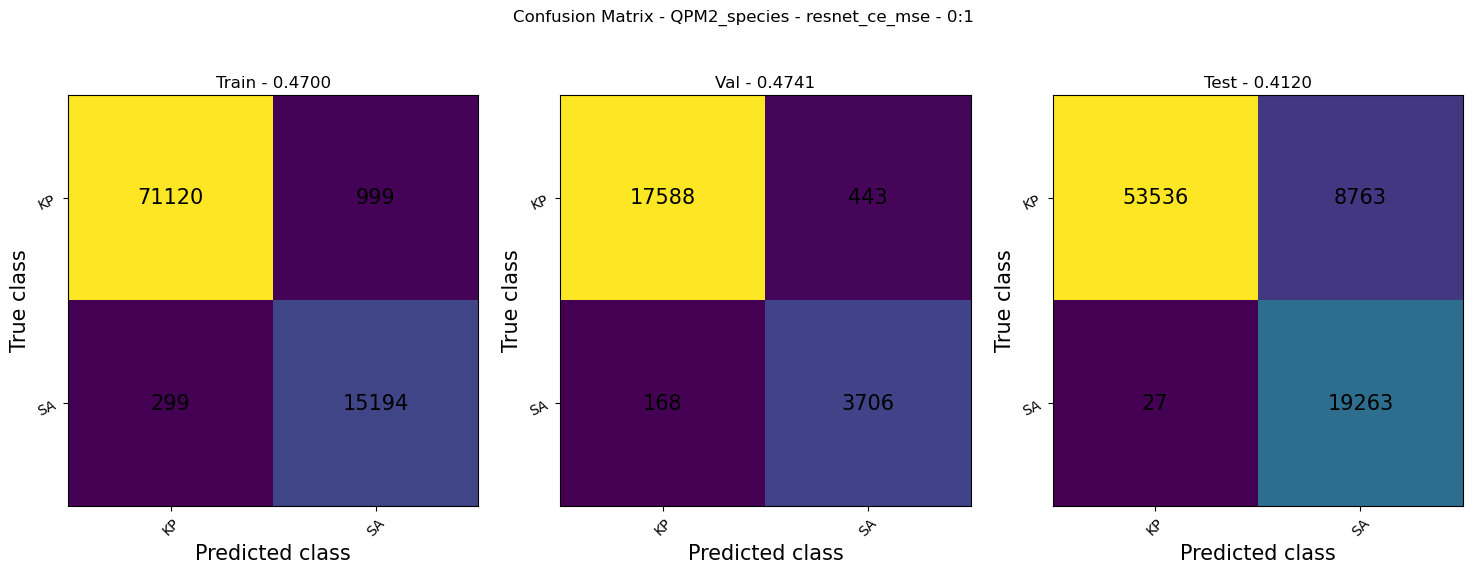

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(81589, 2) (78017, 2)
(81589, 2) (78017, 2)


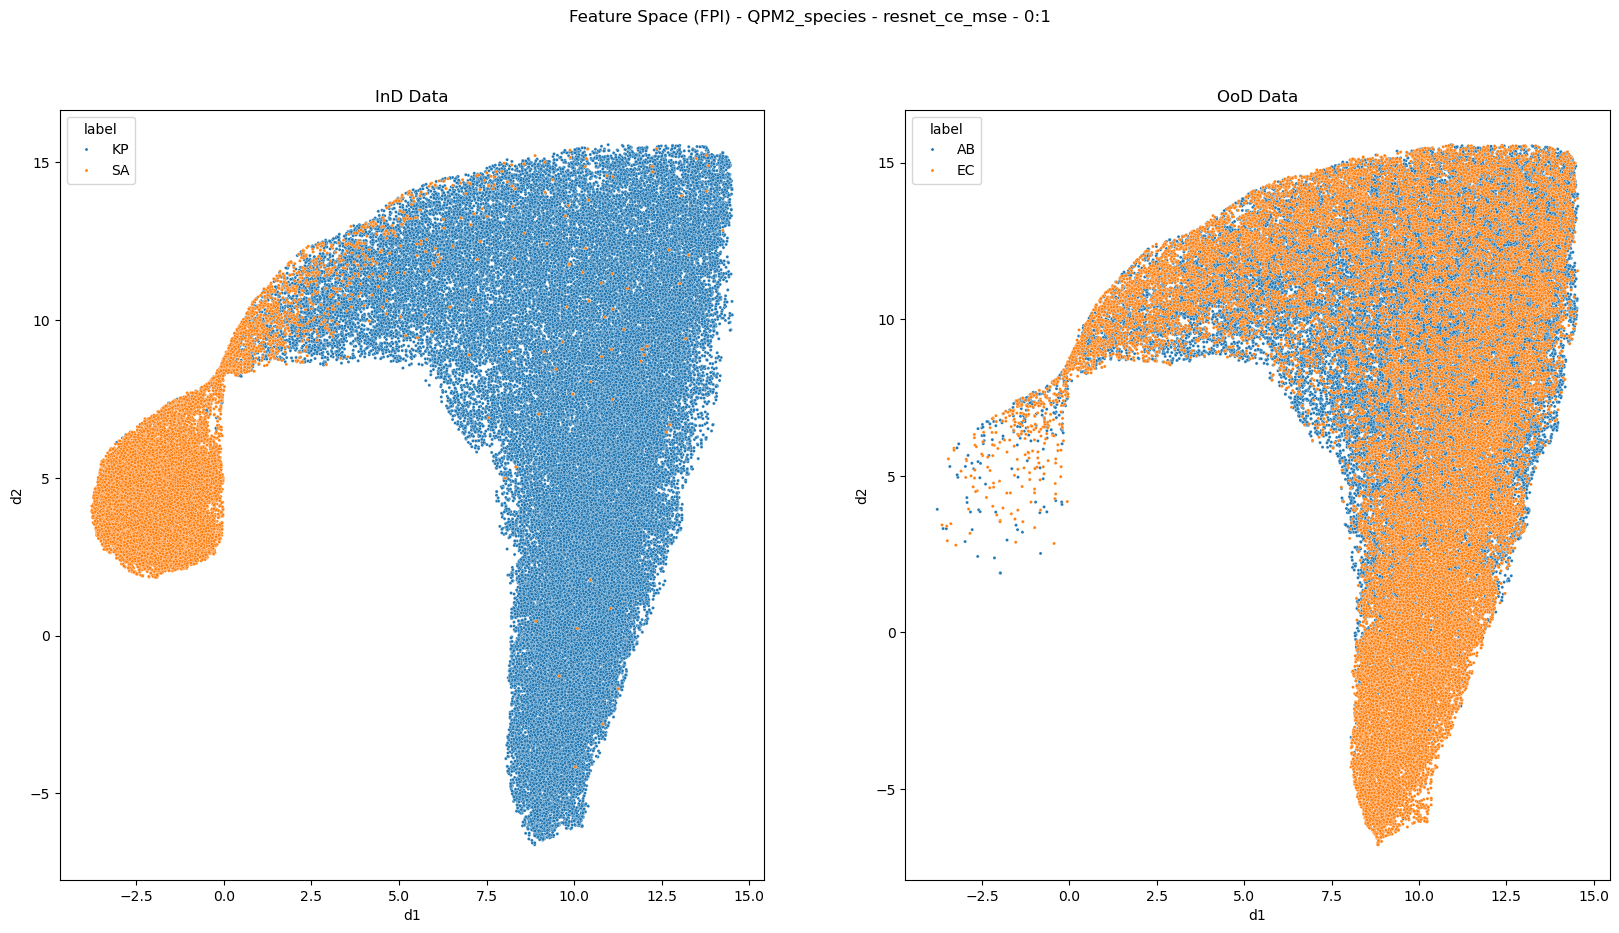

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

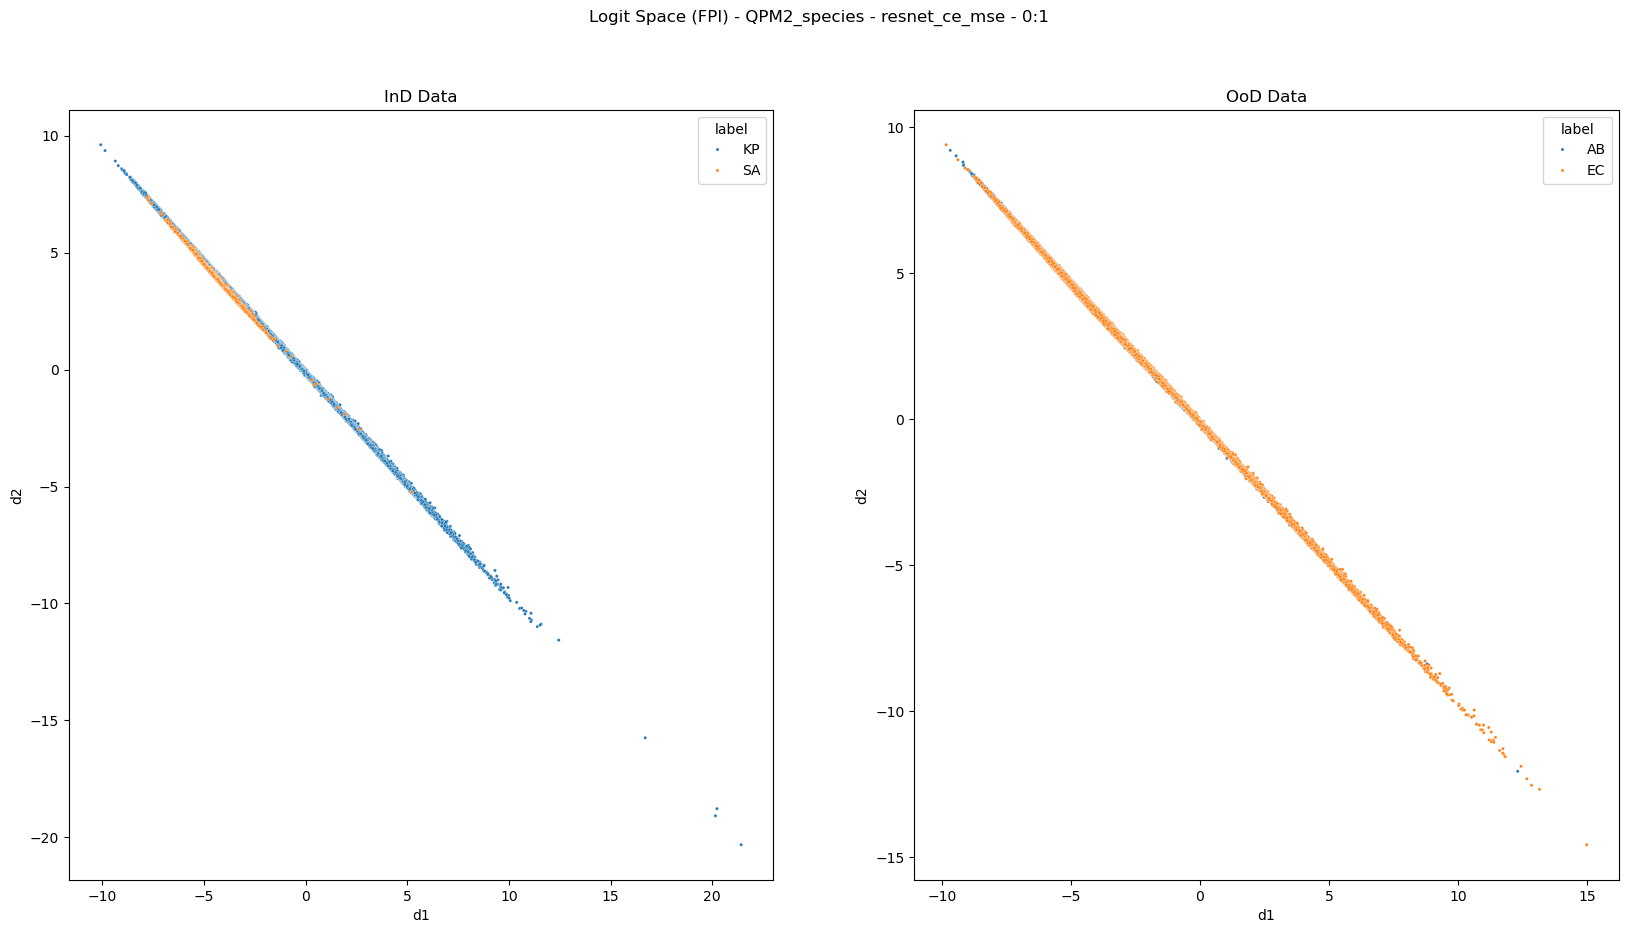

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

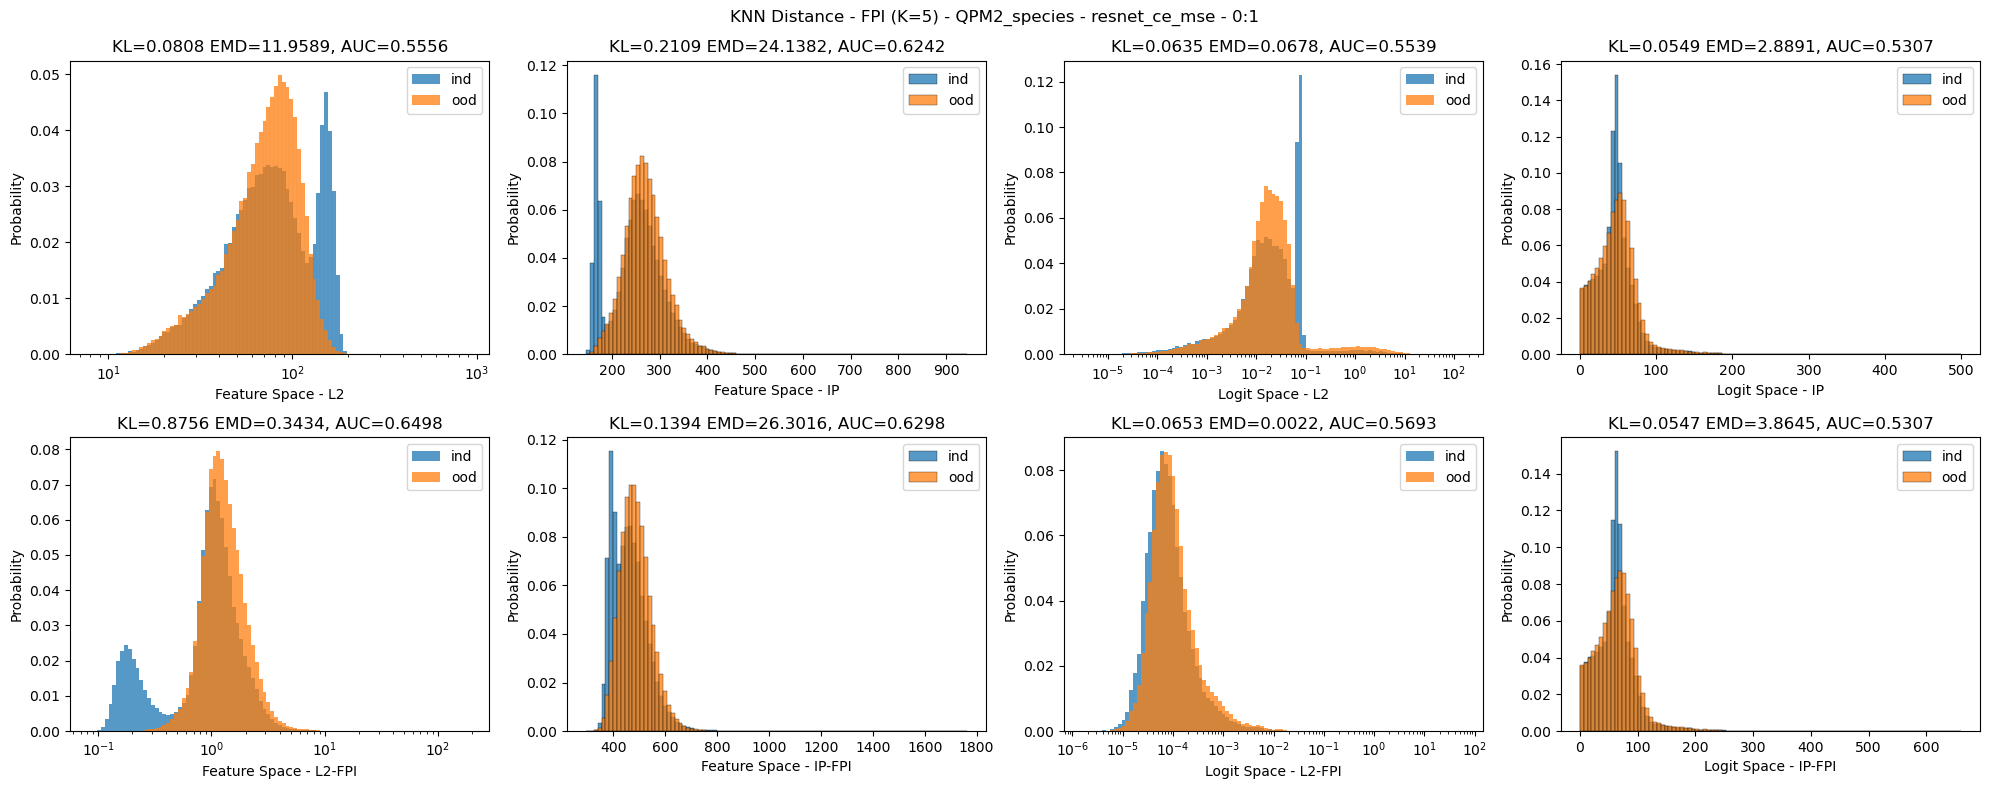

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

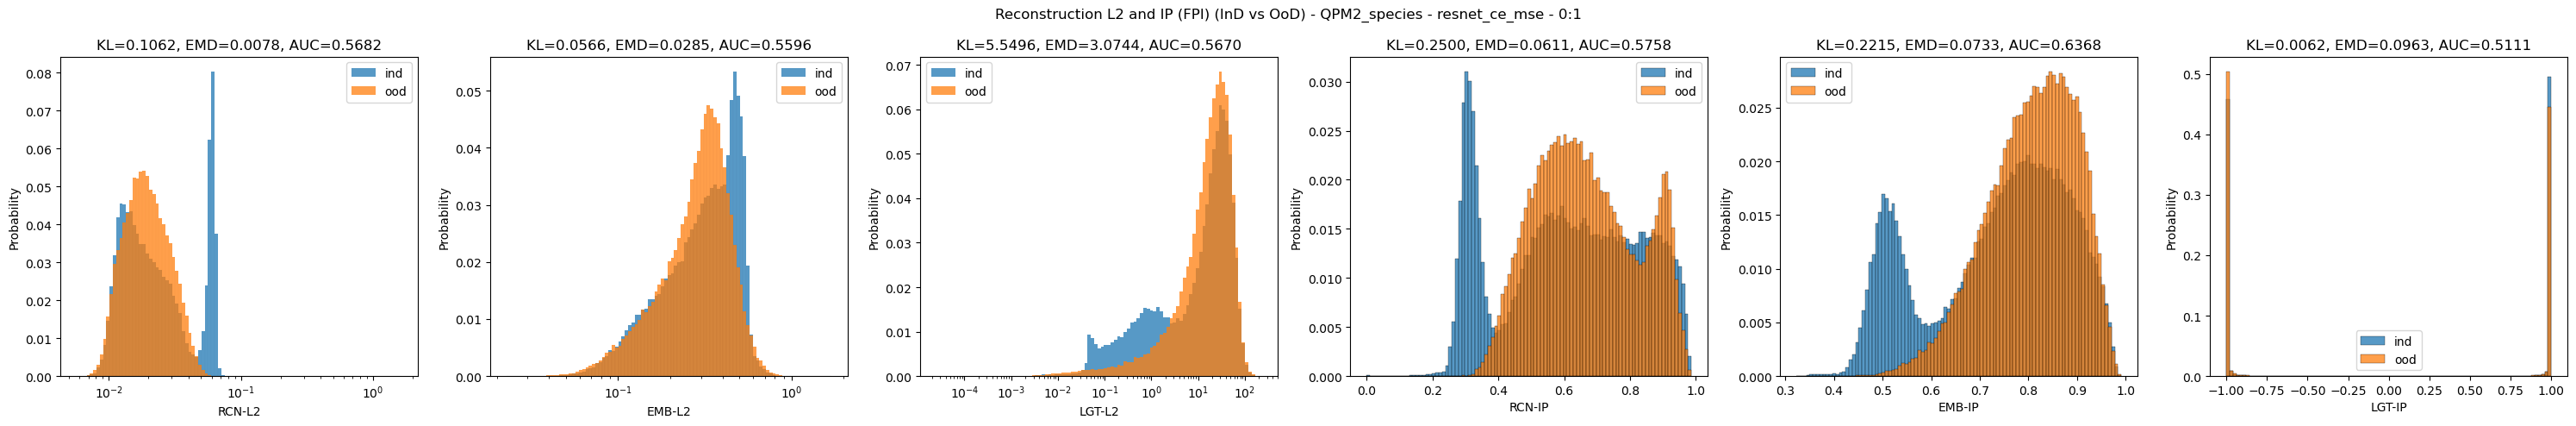

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

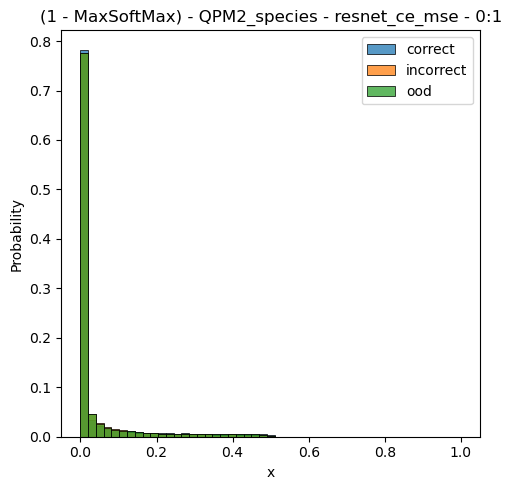

In [17]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()